--- 15.759375095367432 seconds_start se ---
--- 15.898499965667725 seconds_se over-amp start ---
--- 66.60637092590332 seconds_amp over ---
--- 66.60690903663635 seconds_plots ---


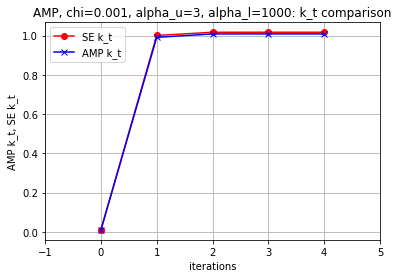

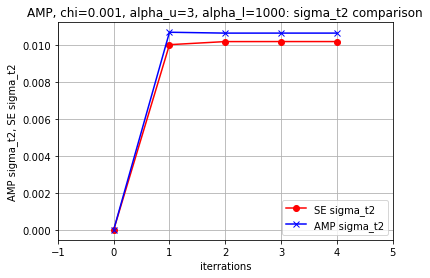

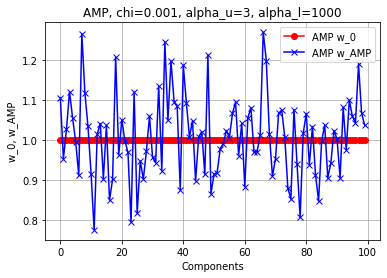

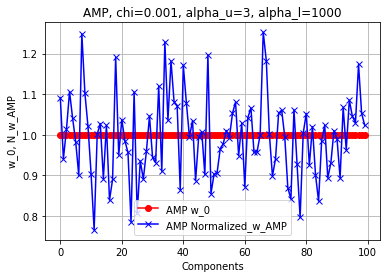

--- 67.37634706497192 seconds_plots over ---


In [550]:
#Homework8 AMP for Gaussian labeled-unlabeled
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion of AMP2
p_collect_amp2 = []
s_collect_amp2 = []
k_collect_amp2 = []
sigma2_collect_amp2 = []
#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []

#hash table: pre-store all the possible y^*
def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

#sampling
n = 100  # dimension
m = 300  # unlabeled data
#m_la = 10000 #labeled data
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n))
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean2, cov)
    else:
        x[i] = np.random.multivariate_normal(mean1, cov)
        
m_la = 10000 #labeled data
alpha_l = m_la/n

x_data = np.zeros((m_la, n))
y_label = np.zeros(m_la)
for i in range(m_la):
    if random.uniform(0, 1) > 0.5:
        y_label[i] = 1
        x_data[i] = np.random.multivariate_normal(mean2, cov)
    else:
        y_label[i] = -1
        x_data[i] = np.random.multivariate_normal(mean1, cov)

def F(p, t):
    return y_s(p,t)/(np.sqrt(t))

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def update_p(s, p, chi):
    p_d = np.zeros(m)
    for u in range(m):
        p_d[u] = (1/np.sqrt(n))*x[u]@s - chi*F(p[u],chi)
    return p_d

def update_s(s, p, chi):
    s_d = np.zeros(n)
    for i in range(n):
        sum_ = 0
        sum_l = 0
        for j in range(m):
            sum_ += chi*((1/np.sqrt(n))*x[j][i]*F(p[j],chi) -(1/n)*s[i]*x[j][i]**2*T(p[j],chi))
        for k in range(m_la):    
            sum_l += chi*x_data[k][i]*y_label[k]/np.sqrt(n)
        s_d[i] = sum_l+ sum_
    return s_d

def amp2(chi):
    s_0 = np.zeros(n)  
    p_0 = np.zeros(m)
    eps=1e-6
    iter_amp2 = 0
    p_new = np.zeros(m)
    s_new = 0.01*np.ones(n)
    def sigma2_update(s_new):
        sigma2_up = 0
        for i in range(n):
            sigma2_up += LA.norm(s_new[i] - k_collect_amp2[iter_amp2])**2/n
        return sigma2_up
    while LA.norm(s_new[0] - s_0[0])>eps:
        p_collect_amp2.append(p_new)
        s_collect_amp2.append(s_new)
        k_collect_amp2.append(s_new@s_Ori/n)
        sigma2_collect_amp2.append(sigma2_update(s_new))
        s_0 = s_new
        p_0 = p_new
        p_new = update_p(s_0,p_0, chi)
        s_new = update_s(s_0,p_new, chi)
        iter_amp2 +=1
    return s_collect_amp2,p_collect_amp2,k_collect_amp2,sigma2_collect_amp2,iter_amp2

def se2(chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_se2 += 1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        k_new = chi*(alpha_l + alpha*sum_f)
        sigma_new = chi**2*(alpha_l + alpha*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return k_collect_se2,sigma2_collect_se2,iter_se2

print("--- %s seconds_start se ---" % (time.time() - start_time))
se2_update = se2(0.01)
print("--- %s seconds_se over-amp start ---" % (time.time() - start_time))
amp2_update = amp2(0.01)
print("--- %s seconds_amp over ---" % (time.time() - start_time))

idx_se2 = []
for index in range(se2_update[2]+1):
    idx_se2.append(index)

idx_amp2 = []
for index in range(amp2_update[4]):
    idx_amp2.append(index)

idx = []
for index in range(n):
    idx.append(index)

iterMin = min(len(idx_se2),len(idx_amp2))   
print("--- %s seconds_plots ---" % (time.time() - start_time))

#figure-1    
plt.plot(idx_se2[:iterMin],se2_update[0][:iterMin],c="r",label="SE k_t",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[2][:iterMin],c="b",label="AMP k_t",marker="x")
plt.title("AMP, chi=0.001, alpha_u=3, alpha_l=1000: k_t comparison")
plt.ylabel("AMP k_t, SE k_t")
plt.xlim(-1,iterMin)
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show()

#figure-2
plt.plot(idx_se2[:iterMin],se2_update[1][:iterMin],c="r",label="SE sigma_t2",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[3][:iterMin],c="b",label="AMP sigma_t2",marker="x")
plt.title("AMP, chi=0.001, alpha_u=3, alpha_l=1000: sigma_t2 comparison")
plt.ylabel("AMP sigma_t2, SE sigma_t2")
plt.xlabel("iterrations")
plt.xlim(-1,iterMin)
plt.grid()
plt.legend()
plt.show()

#figure-3
plt.plot(idx,s_Ori,c="r",label="AMP w_0",marker="o")
plt.plot(idx,amp2_update[0][-1],c="b",label="AMP w_AMP",marker="x")
plt.title("AMP, chi=0.001, alpha_u=3, alpha_l=1000")
plt.ylabel("w_0, w_AMP")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()

#figure-4 Normalized_S
normalized_S = np.sqrt(n)* amp2_update[0][-1]/LA.norm(amp2_update[0][-1])
plt.plot(idx,s_Ori,c="r",label="AMP w_0",marker="o")
plt.plot(idx,normalized_S,c="b",label="AMP Normalized_w_AMP",marker="x")
plt.title("AMP, chi=0.001, alpha_u=3, alpha_l=1000")
plt.ylabel("w_0, N_w_AMP")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()
print("--- %s seconds_plots over ---" % (time.time() - start_time))

In [551]:
amp2_update[0][-1]

array([1.10555038, 0.95353367, 1.02701862, 1.12111202, 1.05469182,
       0.99562298, 0.91220238, 1.26502239, 1.11671049, 1.03401862,
       0.91638788, 0.77571337, 1.01483947, 1.04134912, 0.90403551,
       1.03691647, 0.85025421, 0.9019645 , 1.20650555, 0.96288678,
       1.05113352, 0.99832146, 0.96920106, 0.79562558, 1.11986901,
       0.81676886, 0.94768352, 0.90292789, 0.97199452, 1.05980841,
       0.95680483, 0.94395984, 1.13470865, 0.92248526, 1.24536796,
       1.0498178 , 1.1971792 , 1.09571034, 1.08576398, 0.87593562,
       1.18674173, 1.09345081, 1.0074637 , 1.04860506, 0.89879817,
       1.00805918, 1.02111336, 0.91457746, 1.21256781, 0.8663553 ,
       0.91468727, 0.918967  , 0.97778578, 0.99129613, 1.02391418,
       1.00633562, 1.06710954, 1.09481138, 0.96126678, 1.04180738,
       0.88396182, 1.05604531, 1.08039316, 0.96913141, 0.97085651,
       1.0134609 , 1.26934759, 1.19839123, 1.01466584, 0.9101584 ,
       0.95386144, 1.06685566, 1.07468697, 1.00829447, 0.88069

In [552]:
LA.norm(amp2_update[0][-1] - s_Ori)

1.0339000784577734

In [425]:
a = np.array([1,2])
b = np.array([3,4])
LA.norm(a-b)/2

1.4142135623730951

--- 0.8042337894439697 seconds_start se ---
--- 1.3945000171661377 seconds_se over-amp start ---
--- 277.28980588912964 seconds_amp over ---
--- 277.2903399467468 seconds_plots ---


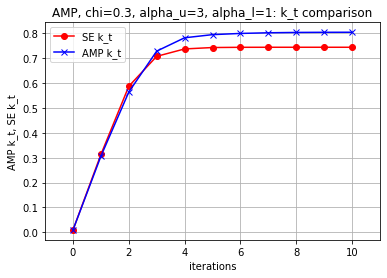

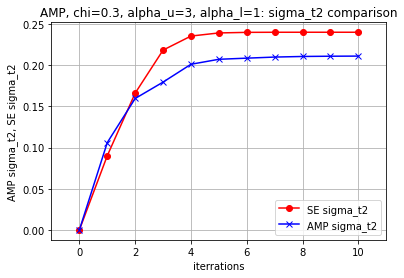

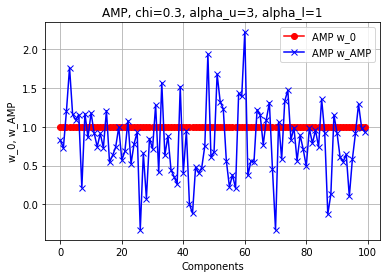

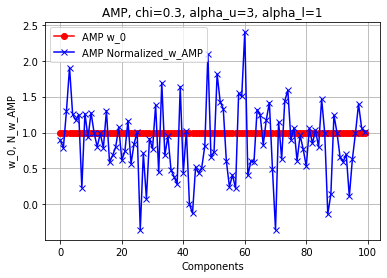

--- 279.45244574546814 seconds_plots over ---


In [97]:
#Homework8 AMP for Gaussian labeled-unlabeled
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion of AMP2
p_collect_amp2 = []
s_collect_amp2 = []
k_collect_amp2 = []
sigma2_collect_amp2 = []
#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

#sampling
n = 100  # dimension
m = 300  # unlabeled data

alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n))
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)

m_la = 100
alpha_l = m_la/n

x_data = np.zeros((m_la, n))
y_label = np.zeros(m_la)
for i in range(m_la):
    if random.uniform(0, 1) > 0.5:
        y_label[i] = 1
        x_data[i] = np.random.multivariate_normal(mean2, cov)
    else:
        y_label[i] = -1
        x_data[i] = np.random.multivariate_normal(mean1, cov)

def F(p, t):
    return y_s(p,t)/(np.sqrt(t))

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def update_p(s, p, chi):
    p_d = np.zeros(m)
    for u in range(m):
        p_d[u] = (1/np.sqrt(n))*x[u]@s - chi*F(p[u],chi)
    return p_d

def update_s(s, p, chi):
    s_d = np.zeros(n)
    for i in range(n):
        sum_ = 0
        sum_l = 0
        for j in range(m):
            sum_ += chi*((1/np.sqrt(n))*x[j][i]*F(p[j],chi) -(1/n)*s[i]*x[j][i]**2*T(p[j],chi))
        for k in range(m_la):    
            sum_l += chi*x_data[k][i]*y_label[k]/np.sqrt(n)
        s_d[i] = sum_l+ sum_
    return s_d

def amp2(chi):
    s_0 = np.zeros(n)  
    p_0 = np.zeros(m)
    eps=1e-6
    iter_amp2 = 0
    p_new = np.zeros(m)
    s_new = 0.01*np.ones(n)
    def sigma2_update(s_new):
        sigma2_up = 0
        for i in range(n):
            sigma2_up += LA.norm(s_new[i] - k_collect_amp2[iter_amp2])**2/n
        return sigma2_up
    while LA.norm(s_new[0] - s_0[0])>eps:
        p_collect_amp2.append(p_new)
        s_collect_amp2.append(s_new)
        k_collect_amp2.append(s_new@s_Ori/n)
        sigma2_collect_amp2.append(sigma2_update(s_new))
        s_0 = s_new
        p_0 = p_new
        p_new = update_p(s_0,p_0, chi)
        s_new = update_s(s_0,p_new, chi)
        iter_amp2 +=1
    return s_collect_amp2,p_collect_amp2,k_collect_amp2,sigma2_collect_amp2,iter_amp2

def se2(chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_se2 += 1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        k_new = chi*(alpha_l + alpha*sum_f)
        sigma_new = chi**2*(alpha_l + alpha*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return k_collect_se2,sigma2_collect_se2,iter_se2

print("--- %s seconds_start se ---" % (time.time() - start_time))
se2_update = se2(0.3)
print("--- %s seconds_se over-amp start ---" % (time.time() - start_time))
amp2_update = amp2(0.3)
print("--- %s seconds_amp over ---" % (time.time() - start_time))

idx_se2 = []
for index in range(se2_update[2]+1):
    idx_se2.append(index)

idx_amp2 = []
for index in range(amp2_update[4]):
    idx_amp2.append(index)

idx = []
for index in range(n):
    idx.append(index)

iterMin = min(len(idx_se2),len(idx_amp2))   
print("--- %s seconds_plots ---" % (time.time() - start_time))

#figure-1    
plt.plot(idx_se2[:iterMin],se2_update[0][:iterMin],c="r",label="SE k_t",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[2][:iterMin],c="b",label="AMP k_t",marker="x")
plt.title("AMP, chi=0.3, alpha_u=3, alpha_l=1: k_t comparison")
plt.ylabel("AMP k_t, SE k_t")
plt.xlim(-1,iterMin)
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show()

#figure-2
plt.plot(idx_se2[:iterMin],se2_update[1][:iterMin],c="r",label="SE sigma_t2",marker="o")
plt.plot(idx_amp2[:iterMin],amp2_update[3][:iterMin],c="b",label="AMP sigma_t2",marker="x")
plt.title("AMP, chi=0.3, alpha_u=3, alpha_l=1: sigma_t2 comparison")
plt.ylabel("AMP sigma_t2, SE sigma_t2")
plt.xlabel("iterrations")
plt.xlim(-1,iterMin)
plt.grid()
plt.legend()
plt.show()

#figure-3
plt.plot(idx,s_Ori,c="r",label="AMP w_0",marker="o")
plt.plot(idx,amp2_update[0][-1],c="b",label="AMP w_AMP",marker="x")
plt.title("AMP, chi=0.3, alpha_u=3, alpha_l=1")
plt.ylabel("w_0, w_AMP")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()

#figure-4 Normalized_S
normalized_S = np.sqrt(n)* amp2_update[0][-1]/LA.norm(amp2_update[0][-1])
plt.plot(idx,s_Ori,c="r",label="AMP w_0",marker="o")
plt.plot(idx,normalized_S,c="b",label="AMP Normalized_w_AMP",marker="x")
plt.title("AMP, chi=0.3, alpha_u=3, alpha_l=1")
plt.ylabel("w_0, N_w_AMP")
plt.xlabel("Components")
plt.grid()
plt.legend()
plt.show()
print("--- %s seconds_plots over ---" % (time.time() - start_time))

In [207]:
#Homework8 AMP for Gaussian labeled-unlabeled
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion of AMP2
p_collect_amp2 = []
s_collect_amp2 = []
k_collect_amp2 = []
sigma2_collect_amp2 = []
#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

#sampling
n = 100  # dimension
m = 300  # unlabeled data
#m_la = 10000 #labeled data
alpha_u = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n))
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)
        
m_la = 10000 #labeled data
alpha_l = m_la/n

x_data = np.zeros((m_la, n))
y_label = np.zeros(m_la)
for i in range(m_la):
    if random.uniform(0, 1) > 0.5:
        y_label[i] = 1
        x_data[i] = np.random.multivariate_normal(mean2, cov)
    else:
        y_label[i] = -1
        x_data[i] = np.random.multivariate_normal(mean1, cov)

def F(p, t):
    return y_s(p,t)/(np.sqrt(t))

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha_u,chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_se2 += 1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        k_new = chi*(alpha_l + alpha_u*sum_f)
        sigma_new = chi**2*(alpha_l + alpha_u*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return k_collect_se2,sigma2_collect_se2,iter_se2

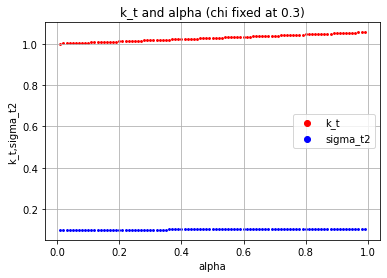

In [208]:
for alpha_u in np.arange(0.01,1,0.01):
    plt.scatter(alpha_u,se2(10,alpha_u,0.1)[0][-1],c="r",s=3.5)
    plt.scatter(alpha_u,se2(10,alpha_u,0.1)[1][-1],c="b",s=3.5)
plt.scatter(0,0,c="r",label="k_t")
plt.scatter(0,0,c="b",label="sigma_t2")
plt.title("k_t and alpha (chi fixed at 0.3)")
plt.ylabel("k_t,sigma_t2")
plt.xlabel("alpha")
plt.grid()
plt.legend()
plt.show()

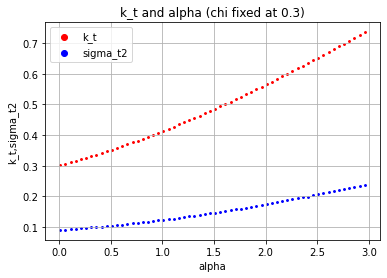

In [112]:
for alpha_u in np.arange(0.01,3,0.05):
    plt.scatter(alpha_u,se2(1,alpha_u,0.3)[0][-1],c="r",s=3.5)
    plt.scatter(alpha_u,se2(1,alpha_u,0.3)[1][-1],c="b",s=3.5)
plt.scatter(0,0,c="r",label="k_t")
plt.scatter(0,0,c="b",label="sigma_t2")
plt.title("k_t and alpha (chi fixed at 0.3)")
plt.ylabel("k_t,sigma_t2")
plt.xlabel("alpha")
plt.grid()
plt.legend()
plt.show()

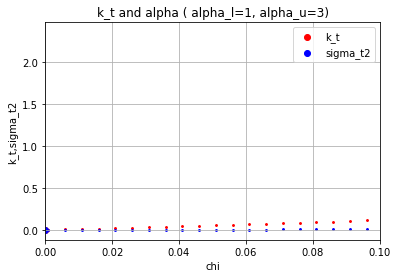

In [119]:
for chi in np.arange(0.001,1,0.005):
    plt.scatter(chi,se2(1,1.5,chi)[0][-1],c="r",s=3.5)
    plt.scatter(chi,se2(1,1.5,chi)[1][-1],c="b",s=3.5)
plt.scatter(0,0,c="r",label="k_t")
plt.scatter(0,0,c="b",label="sigma_t2")
plt.title("k_t and alpha ( alpha_l=1, alpha_u=3)")
plt.ylabel("k_t,sigma_t2")
plt.xlabel("chi")
plt.xlim(0,0.1)
plt.grid()
plt.legend()
plt.show()

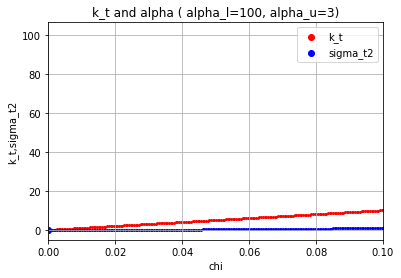

In [120]:
for chi in np.arange(0.0001,1,0.0005):
    plt.scatter(chi,se2(100,1.5,chi)[0][-1],c="r",s=3.5)
    plt.scatter(chi,se2(100,1.5,chi)[1][-1],c="b",s=3.5)
plt.scatter(0,0,c="r",label="k_t")
plt.scatter(0,0,c="b",label="sigma_t2")
plt.title("k_t and alpha ( alpha_l=100, alpha_u=3)")
plt.ylabel("k_t,sigma_t2")
plt.xlabel("chi")
plt.xlim(0,0.1)
plt.grid()
plt.legend()
plt.show()

In [121]:
print("hello")

hello


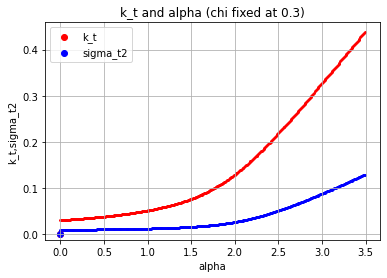

In [125]:
for alpha in np.arange(0.0,3.5,0.01):
    plt.scatter(alpha,se2(0.1,alpha,0.3)[0][-1],c="r",s=3.5)
    plt.scatter(alpha,se2(0.1,alpha,0.3)[1][-1],c="b",s=3.5)
plt.scatter(0,0,c="r",label="k_t")
plt.scatter(0,0,c="b",label="sigma_t2")
plt.title("k_t and alpha (chi fixed at 0.3)")
plt.ylabel("k_t,sigma_t2")
plt.xlabel("alpha")
plt.grid()
plt.legend()
plt.show()

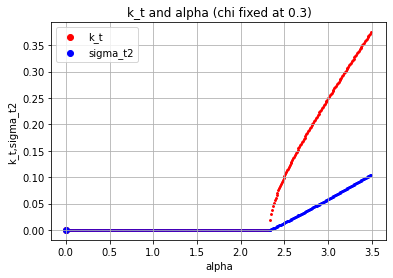

In [126]:
for alpha in np.arange(0.0,3.5,0.01):
    plt.scatter(alpha,se2(0,alpha,0.3)[0][-1],c="r",s=3.5)
    plt.scatter(alpha,se2(0,alpha,0.3)[1][-1],c="b",s=3.5)
plt.scatter(0,0,c="r",label="k_t")
plt.scatter(0,0,c="b",label="sigma_t2")
plt.title("k_t and alpha (chi fixed at 0.3)")
plt.ylabel("k_t,sigma_t2")
plt.xlabel("alpha")
plt.grid()
plt.legend()
plt.show()

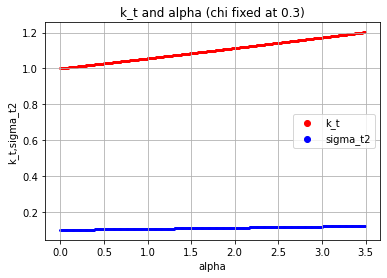

In [128]:
for alpha in np.arange(0.0,3.5,0.01):
    plt.scatter(alpha,se2(10,alpha,0.1)[0][-1],c="r",s=3.5)
    plt.scatter(alpha,se2(10,alpha,0.1)[1][-1],c="b",s=3.5)
plt.scatter(0,0,c="r",label="k_t")
plt.scatter(0,0,c="b",label="sigma_t2")
plt.title("k_t and alpha (chi fixed at 0.3)")
plt.ylabel("k_t,sigma_t2")
plt.xlabel("alpha")
plt.grid()
plt.legend()
plt.show()

In [212]:
#Homework8 AMP for Gaussian labeled-unlabeled SE
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []
chi_collect_se2 = []

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p, t):
    return y_s(p,t)/(np.sqrt(t))

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha_u):
    k_t = 0.01
    chi_t = 0.1
    sigma_s2 = 1
    sigma_02 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([chi_t,k_t,sigma_t2])
    parameter_new = np.array([1,1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    chi_collect_se2.append(chi_t)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([chi_t,k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        sum_t = 0
        iter_se2 += 1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi_t)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi_t)**2/np.sqrt(2*np.pi)/10
            sum_t += np.exp(-1/2*z**2)*T(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi_t)/np.sqrt(2*np.pi)/10
        chi_new = 1/(1/sigma_02 + alpha_l + alpha_u + alpha_u*sum_t)
        k_new = chi_new*(alpha_l + alpha_u*sum_f)
        sigma_new = chi_new**2*(alpha_l + alpha_u*sum_f2)
        parameter_new = np.array([chi_new,k_new,sigma_new])
        chi_collect_se2.append(chi_new)
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        chi_t = chi_new
        k_t = k_new
        sigma_t2 = sigma_new
    return chi_collect_se2,k_collect_se2,sigma2_collect_se2,iter_se2
print("--- %s seconds_SE2 ---" % (time.time() - start_time))

--- 0.0013942718505859375 seconds_SE2 ---


In [213]:
print("chi",se2(0,3)[0][-1])
print("k",se2(0,3)[1][-1])
print("sigma2",se2(0,3)[2][-1])
print("iter",se2(0,3)[3])

chi 0.1339745962157677
k 4.5446518048566233e-07
sigma2 2.0653841004726213e-13
iter 13


In [222]:
print("chi",se2(0.001,3)[0][-1])
print("k",se2(0.001,3)[1][-1])
print("sigma2",se2(0.001,3)[2][-1])
print("iter",se2(0.001,3)[3])

chi 0.1339595895442889
k 0.00025037973087966783
sigma2 1.9342500810581945e-05
iter 13


In [214]:
print("chi",se2(10,3)[0][-1])
print("k",se2(10,3)[1][-1])
print("sigma2",se2(10,3)[2][-1])
print("iter",se2(10,3)[3])

chi 0.06362887508822196
k 0.7294136750232363
sigma2 0.0460086924252492
iter 8


In [221]:
print("chi",se2(0.0001,3)[0][-1])
print("k",se2(0.0001,3)[1][-1])
print("sigma2",se2(0.0001,3)[2][-1])
print("iter",se2(0.0001,3)[3])

chi 0.13397309438815125
k 2.545261134982581e-05
sigma2 1.933813792201538e-06
iter 13


In [209]:
#Homework8 AMP for Gaussian labeled-unlabeled SE
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
start_time = time.time()

#collcetion if SE2
sigma2_collect_se2 = []
k_collect_se2 = []
#chi_collect_se2 = []

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p, t):
    return y_s(p,t)/(np.sqrt(t))

def T(p, t):
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha_u):
    k_t = 0.01
    chi_t = 0.3
    sigma_s2 = 1
    sigma_02 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_se2 = 0
    k_collect_se2.append(0.01)
    sigma2_collect_se2.append(sigma_t2)
    #chi_collect_se2.append(chi_t)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        sum_t = 0
        iter_se2 += 1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi_t)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi_t)**2/np.sqrt(2*np.pi)/10
            sum_t += np.exp(-1/2*z**2)*T(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi_t)/np.sqrt(2*np.pi)/10
        #chi_new = 1/(1/sigma_02 + alpha_l + alpha_u + alpha_u*sum_t)
        k_new = chi_t*(alpha_l + alpha_u*sum_f)
        sigma_new = chi_t**2*(alpha_l + alpha_u*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        #chi_collect_se2.append(chi_new)
        k_collect_se2.append(k_new)
        sigma2_collect_se2.append(sigma_new)
        #chi_t = chi_new
        k_t = k_new
        sigma_t2 = sigma_new
    return k_collect_se2,sigma2_collect_se2,iter_se2
print("--- %s seconds_SE2 ---" % (time.time() - start_time))

--- 0.0024700164794921875 seconds_SE2 ---


In [206]:
print("k",se2(0,1.5)[0][-1])
print("sigma2",se2(0,1.5)[1][-1])
print("iter",se2(0,1.5)[2])

k 1.4515715961495895e-06
sigma2 8.425700677375276e-12
iter 20


In [189]:
print("k",se2(0,2)[0][-1])
print("sigma2",se2(0,2)[1][-1])
print("iter",se2(0,2)[2])

k 5.229026060715122e-06
sigma2 5.468541939657142e-11
iter 49


In [190]:
print("k",se2(0,3)[0][-1])
print("sigma2",se2(0,3)[1][-1])
print("iter",se2(0,3)[2])

k 0.24961958820346403
sigma2 0.058166119286205346
iter 40


In [191]:
print("k",se2(1,3)[0][-1])
print("sigma2",se2(1,3)[1][-1])
print("iter",se2(1,3)[2])

k 0.7433088701213098
sigma2 0.24001409515108296
iter 10


In [192]:
print("k",se2(0.1,3)[0][-1])
print("sigma2",se2(0.1,3)[1][-1])
print("iter",se2(0.1,3)[2])

k 0.32686907960298667
sigma2 0.08748472668065495
iter 24


In [193]:
print("k",se2(1000,3)[0][-1])
print("sigma2",se2(1000,3)[1][-1])
print("iter",se2(1000,3)[2])

k 300.60948638610677
sigma2 90.2637546319979
iter 4


In [447]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

n = 100  # dimension
m = 300  # unlabeled data size
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n)) #unlabeled data
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)
        
m_la = 10000 #labeled data
alpha_l = m_la/n

x_data = np.zeros((m_la, n)) #labeled data
y_label = np.zeros(m_la)
for i in range(m_la):
    if random.uniform(0, 1) > 0.5:
        y_label[i] = 1
        x_data[i] = np.random.multivariate_normal(mean2, cov)
    else:
        y_label[i] = -1
        x_data[i] = np.random.multivariate_normal(mean1, cov)
        
eps =1e-10
s_init= 2*np.ones(n)
s_new = np.zeros(n)
sum_la = np.zeros(n)
rho = 1e-5
for i in range(m_la):
    sum_la += x_data[i]*y_label[i]/(np.sqrt(n))
iter_ = 0
maxiter_ =3000
while True:
    sum_un = np.zeros(n)
    for i in range(m):
        sum_un+= np.tanh(x[i]@s_init/np.sqrt(n))*x[i]/np.sqrt(n)
    s_new = s_init + rho*(-(alpha_l+alpha+1)*s_init + sum_la + sum_un)
    if LA.norm(s_new - s_init)<eps or iter_>maxiter_:
        break
    s_init = s_new
    iter_+=1

In [448]:
iter_

3001

In [449]:
s_new

array([1.05339113, 1.09022093, 1.00886382, 1.06266247, 1.14536446,
       1.00629938, 0.96441221, 1.03937706, 1.04827074, 0.9820956 ,
       0.91900732, 0.86742593, 1.00415559, 0.8650671 , 0.96914301,
       1.22699028, 0.93386324, 0.96171514, 0.97263846, 1.0088799 ,
       0.97744691, 1.11300231, 1.0990951 , 1.04346564, 1.04448373,
       1.03172305, 1.08012242, 1.04406864, 1.15489332, 1.18729279,
       1.17674519, 0.89412217, 1.04388647, 1.06435864, 0.98767444,
       0.96074474, 1.10508603, 0.96468147, 0.88886439, 1.0877776 ,
       1.09127239, 1.0665748 , 0.99491577, 1.13409725, 1.16256295,
       1.05584249, 1.08355151, 0.93913763, 1.01654975, 1.21374112,
       1.06934996, 0.81254065, 1.10638177, 0.91652351, 1.0850685 ,
       1.00144457, 0.97797781, 1.17035902, 0.91748077, 0.903993  ,
       0.9872897 , 1.20935383, 0.99665529, 0.95074489, 0.8877282 ,
       1.16680712, 1.05261173, 1.16519393, 1.03842944, 1.09649982,
       1.01676187, 0.96111335, 1.15740504, 0.95410094, 1.16983

In [450]:
LA.norm(s_new - s_Ori)

1.0053719643754413

In [392]:
n = 100  # dimension
m = 300  # unlabeled data size
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n)) #unlabeled data
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)
        
m_la = 10000 #labeled data
alpha_l = m_la/n

x_data = np.zeros((m_la, n)) #labeled data
y_label = np.zeros(m_la)
for i in range(m_la):
    if random.uniform(0, 1) > 0.5:
        y_label[i] = 1
        x_data[i] = np.random.multivariate_normal(mean2, cov)
    else:
        y_label[i] = -1
        x_data[i] = np.random.multivariate_normal(mean1, cov)

In [393]:
sum_la = np.zeros(n)
for i in range(m_la):
    sum_la += x_data[i]*y_label[i]/(2*np.sqrt(n))
sum_la

array([44.61969157, 55.6576735 , 54.72290763, 53.72158186, 52.98312612,
       40.37555289, 48.48487569, 44.70515738, 47.23150745, 49.35653649,
       66.06363987, 50.93133352, 52.06512912, 49.34613465, 49.80040405,
       51.59383477, 48.71357204, 51.77122642, 46.05736406, 51.12864037,
       61.96395885, 48.70041598, 47.11849976, 46.12482878, 52.37614971,
       52.41540068, 49.50353493, 53.44724679, 37.43804851, 54.83395138,
       47.43983676, 55.41962201, 56.15916679, 52.56314773, 48.65619247,
       49.72076447, 51.13121358, 48.2509257 , 49.9012355 , 43.16780724,
       50.08162394, 54.07681537, 45.18436788, 44.55711139, 47.45634707,
       50.88694677, 52.50853433, 53.00458079, 55.64898595, 52.57668307,
       50.20081391, 41.99259431, 54.9829754 , 40.99027502, 51.5585027 ,
       51.85027624, 51.6515861 , 46.65832476, 40.21897159, 49.89322917,
       48.0845243 , 57.20408159, 48.99485828, 48.61536583, 37.68792208,
       55.85184047, 52.86964579, 57.0961673 , 41.6569956 , 38.40

In [ ]:
sum_un = np.zeros(n)
for i in range(m):
    sum_un+= np.tanh(x[i]@s_Ori/np.sqrt(n))*x[i]/np.sqrt(n)
sum_un

In [269]:
rho = 1e-2
s_new = s_Ori + rho*(-(alpha_l+alpha)*s_Ori + sum_la + sum_un)
s_new

array([0.46094636, 0.4823864 , 0.49648839, 0.50150684, 0.50209625,
       0.45936589, 0.49257849, 0.52081856, 0.43435412, 0.51778808,
       0.53801514, 0.5442772 , 0.57081241, 0.49458402, 0.48620239,
       0.47726025, 0.54943015, 0.49604536, 0.37073649, 0.49055723,
       0.52524336, 0.42528868, 0.43858058, 0.51261215, 0.51453999,
       0.53301115, 0.43721065, 0.50150337, 0.50286966, 0.66440483,
       0.44573427, 0.53192721, 0.61301718, 0.55491079, 0.54157797,
       0.39359965, 0.4751535 , 0.46340042, 0.41129018, 0.42146702,
       0.54208294, 0.48463881, 0.50012207, 0.48904721, 0.48318472,
       0.5904616 , 0.43789896, 0.45096943, 0.46268558, 0.42250358,
       0.52106836, 0.50310717, 0.49197511, 0.4707499 , 0.48263553,
       0.56406703, 0.52775149, 0.50820403, 0.4491184 , 0.49877548,
       0.45060467, 0.55678825, 0.5099493 , 0.46789093, 0.50583196,
       0.49449964, 0.51827332, 0.56332255, 0.49134668, 0.55485794,
       0.44011422, 0.5156834 , 0.40499329, 0.49075683, 0.51563

In [270]:
sum_un = np.zeros(n)
for i in range(m):
    sum_un+= np.tanh(x[i]@s_new/np.sqrt(n))*x[i]/np.sqrt(n)
sum_un

array([ 0.61585995,  2.46023652,  2.49358412,  2.11695704,  2.56089595,
        2.47968212,  2.65999105,  2.02310633,  1.84303425,  3.30642907,
        2.28058514,  3.21899335,  5.2264164 ,  1.6119973 ,  2.42057035,
        1.02445019,  2.59763394,  2.00142776,  2.13219621,  3.21587147,
        2.65742519,  2.62513207,  3.11465646,  2.67323986,  2.23508441,
        1.41632139,  0.43711059,  2.16341506,  0.84784411,  2.95268332,
        0.77532266,  1.89722082,  2.10154844,  3.10711675,  3.05539851,
        1.30436031,  2.59160871,  2.24386198,  1.85493069, -0.90086477,
        3.23770182,  3.05588972,  3.43409081,  3.06019571,  2.03502127,
        2.64225395,  3.96407672,  3.85793643,  2.18080243,  1.13011458,
        2.27101458, -0.27507181,  1.33469569,  1.80003977,  0.98987954,
        2.25939414,  2.81498849,  2.95790309,  1.81855318,  2.84636044,
        0.60410907,  1.79466851,  1.62873936,  3.86124386,  2.33953326,
        2.78124113,  3.33979099,  2.68940385,  3.50816448,  3.48

In [271]:
s_new = s_new + rho*(-(alpha_l+alpha)*s_new + sum_la + sum_un)
s_new

array([0.47686921, 0.48737921, 0.50319584, 0.51154794, 0.50840038,
       0.46888481, 0.49994015, 0.52751406, 0.44605894, 0.52296452,
       0.54584627, 0.54810619, 0.56742218, 0.50497856, 0.49246937,
       0.49067947, 0.55557764, 0.50305462, 0.37947949, 0.49678629,
       0.53068291, 0.42962994, 0.44555772, 0.52206091, 0.52073747,
       0.5433813 , 0.45434766, 0.50908627, 0.51566592, 0.66909804,
       0.45614303, 0.54214208, 0.61863364, 0.55640841, 0.54721996,
       0.4047525 , 0.48216937, 0.47233427, 0.41887221, 0.44264929,
       0.54824867, 0.48890629, 0.50111852, 0.495456  , 0.4914522 ,
       0.59638597, 0.43706185, 0.44981579, 0.47236605, 0.43362743,
       0.525804  , 0.52366837, 0.50656167, 0.48132241, 0.49499427,
       0.56990863, 0.53281939, 0.5161029 , 0.45702008, 0.50116742,
       0.46602594, 0.5680482 , 0.51856531, 0.4689413 , 0.51536325,
       0.50408868, 0.52284968, 0.57426789, 0.4966389 , 0.56252161,
       0.44637627, 0.5223636 , 0.41431556, 0.50234785, 0.52368

In [262]:
x_data[0].shape

(100,)

In [232]:
np.tanh(x[1]@s_Ori/np.sqrt(n))*x[1]/np.sqrt(n)

array([ 0.08508025, -0.10701922,  0.05542076, -0.05375707, -0.09258835,
        0.10571201,  0.11678012,  0.02227305,  0.08800302,  0.0474345 ,
        0.05977098,  0.05764854, -0.00552679, -0.03384645,  0.02582633,
        0.01445889,  0.08017699,  0.06262094,  0.0878649 , -0.07674894,
       -0.11114251, -0.09549496, -0.03607333,  0.06672902, -0.03579156,
       -0.04473047,  0.01556413, -0.05524137,  0.04574559,  0.08222612,
        0.00595931,  0.01588983,  0.03710328,  0.04498761, -0.1154535 ,
       -0.04819138,  0.14463062,  0.04308803, -0.11477623, -0.06337736,
        0.0390976 , -0.06367001, -0.10026773, -0.05330286,  0.08365883,
        0.03290844, -0.00215118, -0.06956101, -0.00422203,  0.13270913,
       -0.07185054,  0.11517512,  0.0911181 ,  0.01986682,  0.18360748,
        0.12817944,  0.1365033 ,  0.02186815, -0.06710452, -0.09272408,
        0.12592523, -0.01211069, -0.15235075,  0.0361796 , -0.06574781,
        0.08598644, -0.00241077, -0.04885308, -0.07448314, -0.03

In [453]:
import math
math.exp(2)

7.38905609893065

In [455]:
x_data[1]@s_Ori

2.423691151881811

In [460]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math

n = 100  # dimension
m = 300  # unlabeled data size
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n)) #unlabeled data
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)
        
m_la = 10000 #labeled data
alpha_l = m_la/n

x_data = np.zeros((m_la, n)) #labeled data
y_label = np.zeros(m_la)
for i in range(m_la):
    if random.uniform(0, 1) > 0.5:
        y_label[i] = 1
        x_data[i] = np.random.multivariate_normal(mean2, cov)
    else:
        y_label[i] = -1
        x_data[i] = np.random.multivariate_normal(mean1, cov)
        
eps =1e-10
s_init= 2*np.ones(n)
s_new = np.zeros(n)
sum_la = np.zeros(n)
rho = 0.45
gamma = 1e-5
for i in range(m_la):
    sum_la += x_data[i]*y_label[i]/(np.sqrt(n))
iter_ = 0
maxiter_ =3000
while True:
    sum_un = np.zeros(n)
    for i in range(m):
        sum_un+= (2*rho*np.cosh(x[i]@s_init/np.sqrt(n))-math.exp(-x[i]@s_init/np.sqrt(n)))
        /(2*rho*np.sinh(x[i]@s_init/np.sqrt(n))-math.exp(x[i]@s_init/np.sqrt(n)))*x[i]/np.sqrt(n)
    s_new = s_init + gamma*(-(alpha_l+alpha+1)*s_init + sum_la + sum_un)
    if LA.norm(s_new - s_init)<eps or iter_>maxiter_:
        break
    s_init = s_new
    iter_+=1
s_new

array([1.05355177, 1.11521652, 0.8476292 , 0.92675144, 0.95604909,
       1.0272752 , 0.81161382, 1.07031342, 0.88481224, 0.85471742,
       0.97376181, 1.02383999, 0.98245594, 1.04415467, 1.05720041,
       0.87037404, 1.05170136, 0.9382018 , 0.89255762, 1.08675933,
       1.09099193, 0.96457427, 1.22389928, 0.92978813, 1.09514503,
       1.08477867, 0.86998025, 0.96009329, 1.00724044, 1.22114827,
       0.97133754, 0.98625055, 0.98772122, 1.08741419, 1.02439353,
       1.04683309, 0.81702868, 0.97653219, 1.00149167, 1.08506648,
       1.15125023, 1.05506003, 0.98103959, 0.9854449 , 0.97274087,
       0.90913349, 0.95291389, 0.92436081, 1.02796286, 1.09949394,
       0.95387926, 1.10627491, 0.98451654, 1.1152146 , 0.76064728,
       0.95816558, 1.00775326, 0.96771886, 1.13216056, 0.91026636,
       0.91556472, 1.01588031, 0.97015489, 1.07008998, 1.0040089 ,
       0.9231089 , 1.00004177, 0.94108838, 0.99176891, 1.10142854,
       0.89814658, 0.90975791, 0.93853922, 0.95841918, 0.99905

In [461]:
iter_

3001

In [462]:
LA.norm(s_new-s_Ori)/100

0.009084556879079903

In [518]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math

n = 100  # dimension
m = 300  # unlabeled data size
alpha = m/n
s_Ori = np.ones(n)
mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
mean2 = 1/np.sqrt(n)*np.ones(n)
cov = np.identity(n)
x = np.zeros((m, n)) #unlabeled data
for i in range(m):
    if random.uniform(0, 1) > 0.5:
        x[i] = np.random.multivariate_normal(mean1, cov)
    else:
        x[i] = np.random.multivariate_normal(mean2, cov)
        
m_la = 10000 #labeled data
alpha_l = m_la/n

x_data = np.zeros((m_la, n)) #labeled data
y_label = np.zeros(m_la)
for i in range(m_la):
    if random.uniform(0, 1) > 0.5:
        y_label[i] = 1
        x_data[i] = np.random.multivariate_normal(mean2, cov)
    else:
        y_label[i] = -1
        x_data[i] = np.random.multivariate_normal(mean1, cov)

def GA(rho):
    eps =1e-8
    s_init= 2*np.ones(n)
    s_new = np.zeros(n)
    sum_la = np.zeros(n)
    #rho = 0.8
    gamma = 1e-4
    for i in range(m_la):
        sum_la += x_data[i]*y_label[i]/(np.sqrt(n))
    iter_ = 0
    maxiter_ =1e3
    Error = []
    while True:
        sum_un = np.zeros(n)
        for i in range(m):
            sum_un+= (2*rho*np.cosh(x[i]@s_init/np.sqrt(n))-math.exp(-x[i]@s_init/np.sqrt(n)))/(2*rho*np.sinh(x[i]@s_init/np.sqrt(n))+math.exp(-x[i]@s_init/np.sqrt(n)))*x[i]/np.sqrt(n)
        s_new = s_init + gamma*(-(alpha_l+alpha+1)*s_init + sum_la + sum_un)
        Error.append(LA.norm(s_new - s_Ori)/n)
        if LA.norm(s_new - s_init)<eps or iter_>maxiter_:
            break
        s_init = s_new
        iter_+=1
    return s_new,Error

In [519]:
GA(0.8)[0]

array([1.01554212, 1.0719848 , 1.1470211 , 1.01919045, 1.02376177,
       1.13960064, 0.99138194, 1.14178794, 0.9754288 , 1.11054468,
       0.83379348, 1.04944526, 1.05148778, 0.74256342, 0.89340157,
       1.04403133, 0.94036147, 0.98783831, 1.04947722, 1.16204613,
       1.02182307, 0.89683022, 0.91769923, 1.1520472 , 0.97147506,
       1.10104202, 0.97011804, 0.96403729, 0.93691738, 1.19448398,
       1.01643208, 1.00066499, 0.9695743 , 0.94579968, 0.89463811,
       1.01832308, 1.02439585, 0.96562585, 1.00341325, 1.00214929,
       0.86821643, 0.85043635, 1.06415861, 0.98651842, 1.02316855,
       0.88982247, 1.14158686, 1.01264048, 1.33695188, 1.13588363,
       0.94978471, 1.15718692, 1.09257741, 1.2302051 , 1.02886326,
       1.1368558 , 0.95962935, 0.81111827, 1.01733718, 0.94097577,
       0.99905979, 0.92525203, 1.06024378, 1.00659504, 0.80083828,
       0.99610905, 0.98144729, 0.84203371, 0.8310988 , 0.97273379,
       1.01891705, 0.99251949, 0.81812778, 0.69072879, 0.95861

In [520]:
a = GA(0.8)[1]
b = []
for i in range(len(GA(0.8)[1])):
    b.append(i)

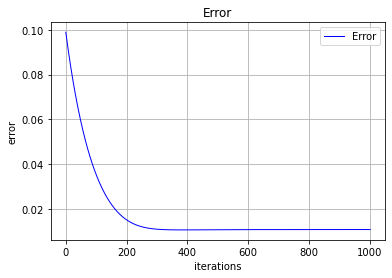

In [521]:
plt.plot(b,a,"b-",label="Error",linewidth=1)
plt.title("Error")
plt.ylabel("error")
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show() 

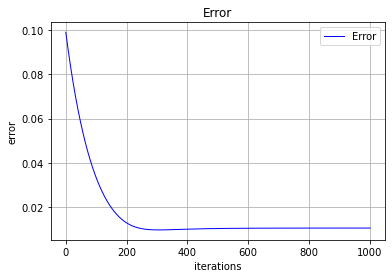

In [522]:
a = GA(0)[1]
b = []
for i in range(len(GA(0)[1])):
    b.append(i)

plt.plot(b,a,"b-",label="Error",linewidth=1)
plt.title("Error")
plt.ylabel("error")
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show() 

/var/folders/h_/mft4g8yj4p5b9mc1x71fgd680000gn/T/ipykernel_1942/2585698156.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(iter_,GA(rho)[1],"b-",label="Error",ls = l[int(rho*10)],linewidth=1)


ValueError: '-.-' is not a valid value for ls; supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

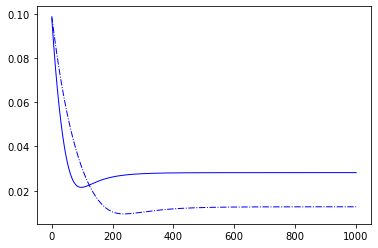

In [516]:
iter_ = []
l = ['-','--','-.',':','-.-'] 
for i in range(len(GA(0.8)[1])):
    iter_.append(i)
for rho in np.arange(0.01,1,0.2):
    plt.plot(iter_,GA(rho)[1],"b-",label="Error",ls = l[int(rho*10)],linewidth=1)
plt.title("Gradient Ascent Error")
plt.ylabel("1/N(w_GA - w_0)^2 error")
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show()     

In [ ]:
iter_

In [496]:
LA.norm(s_new-s_Ori)/100

0.00992246760963209

In [548]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math

def GA(rho):
    n = 100  # dimension
    m = 300  # unlabeled data size
    alpha = m/n
    s_Ori = np.ones(n)
    mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
    mean2 = 1/np.sqrt(n)*np.ones(n)
    cov = np.identity(n)
    x = np.zeros((m, n)) #unlabeled data
    for i in range(m):
        if random.uniform(0, 1) > rho:
            x[i] = np.random.multivariate_normal(mean2, cov)
        else:
            x[i] = np.random.multivariate_normal(mean1, cov)

    m_la = 10000 #labeled data
    alpha_l = m_la/n

    x_data = np.zeros((m_la, n)) #labeled data
    y_label = np.zeros(m_la)
    for i in range(m_la):
        if random.uniform(0, 1) > rho:
            y_label[i] = 1
            x_data[i] = np.random.multivariate_normal(mean2, cov)
        else:
            y_label[i] = -1
            x_data[i] = np.random.multivariate_normal(mean1, cov)
            
    eps =1e-8
    s_init= 2*np.ones(n)
    s_new = np.zeros(n)
    sum_la = np.zeros(n)
    #rho = 0.8
    gamma = 1e-4
    for i in range(m_la):
        sum_la += x_data[i]*y_label[i]/(np.sqrt(n))
    iter_ = 0
    maxiter_ =1e3
    Error = []
    while True:
        sum_un = np.zeros(n)
        for i in range(m):
            sum_un+= (2*rho*np.cosh(x[i]@s_init/np.sqrt(n))-math.exp(-x[i]@s_init/np.sqrt(n)))/(2*rho*np.sinh(x[i]@s_init/np.sqrt(n))+math.exp(-x[i]@s_init/np.sqrt(n)))*x[i]/np.sqrt(n)
        s_new = s_init + gamma*(-(alpha_l+alpha+1)*s_init + sum_la + sum_un)
        Error.append(LA.norm(s_new - s_Ori)/n)
        if LA.norm(s_new - s_init)<eps or iter_>maxiter_:
            break
        s_init = s_new
        iter_+=1
    return s_new,Error

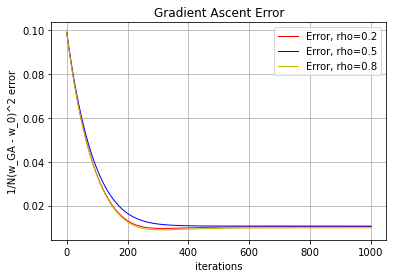

In [553]:
iterPlot = []
for i in range(1002):
    iterPlot.append(i)
plt.plot(iterPlot,GA(0.2)[1],"r-",label="Error, rho=0.2",linewidth=1)
plt.plot(iterPlot,GA(0.5)[1],"b-",label="Error, rho=0.5",linewidth=1)
plt.plot(iterPlot,GA(0.8)[1],"y-",label="Error, rho=0.8",linewidth=1)
plt.title("Gradient Ascent Error")
plt.ylabel("1/N(w_GA - w_0)^2 error")
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show() 

rho=0 0.9754633875210129
rho=0.2 0.8801231226524225
rho=0.5 1.017095590274898
rho=0.8 0.9463900113752085
rho=1 0.8605624983886796


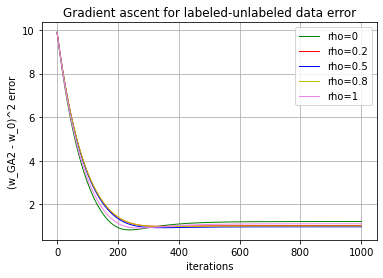

In [561]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import math

def GA(rho):
    n = 100  # dimension
    m = 300  # unlabeled data size
    alpha = m/n
    s_Ori = np.ones(n)
    mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
    mean2 = 1/np.sqrt(n)*np.ones(n)
    cov = np.identity(n)
    x = np.zeros((m, n)) #unlabeled data
    for i in range(m):
        if random.uniform(0, 1) > rho:
            x[i] = np.random.multivariate_normal(mean2, cov)
        else:
            x[i] = np.random.multivariate_normal(mean1, cov)

    m_la = 10000 #labeled data
    alpha_l = m_la/n

    x_data = np.zeros((m_la, n)) #labeled data
    y_label = np.zeros(m_la)
    for i in range(m_la):
        if random.uniform(0, 1) > rho:
            y_label[i] = 1
            x_data[i] = np.random.multivariate_normal(mean2, cov)
        else:
            y_label[i] = -1
            x_data[i] = np.random.multivariate_normal(mean1, cov)
            
    eps =1e-8
    s_init= 2*np.ones(n)
    s_new = np.zeros(n)
    sum_la = np.zeros(n)
    #rho = 0.8
    gamma = 1e-4
    for i in range(m_la):
        sum_la += x_data[i]*y_label[i]/(np.sqrt(n))
    iter_ = 0
    maxiter_ =1e3
    Error = []
    while True:
        sum_un = np.zeros(n)
        for i in range(m):
            sum_un+= (2*rho*np.cosh(x[i]@s_init/np.sqrt(n))-math.exp(-x[i]@s_init/np.sqrt(n)))/(2*rho*np.sinh(x[i]@s_init/np.sqrt(n))+math.exp(-x[i]@s_init/np.sqrt(n)))*x[i]/np.sqrt(n)
        s_new = s_init + gamma*(-(alpha_l+alpha+1)*s_init + sum_la + sum_un)
        Error.append(LA.norm(s_new - s_Ori))
        if LA.norm(s_new - s_init)<eps or iter_>maxiter_:
            break
        s_init = s_new
        iter_+=1
    return s_new,Error

G1 = GA(0)
G2 = GA(0.2)
G3 = GA(0.5)
G4 = GA(0.8)
G5 = GA(1)
iterPlot = []
for i in range(1002):
    iterPlot.append(i)
plt.plot(iterPlot,G1[1],"g-",label="rho=0",linewidth=1)
plt.plot(iterPlot,G2[1],"r-",label="rho=0.2",linewidth=1)
plt.plot(iterPlot,G3[1],"b-",label="rho=0.5",linewidth=1)
plt.plot(iterPlot,G4[1],"y-",label="rho=0.8",linewidth=1)
plt.plot(iterPlot,G5[1],"violet",label="rho=1",linewidth=1)
print("rho=0",G1[0][-1])
print("rho=0.2",G2[0][-1])
print("rho=0.5",G3[0][-1])
print("rho=0.8",G4[0][-1])
print("rho=1",G5[0][-1])
plt.title("Gradient ascent for labeled-unlabeled data error")
plt.ylabel("(w_GA2 - w_0)^2 error")
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show() 

In [566]:
print(G1[1][-1])
print(G2[1][-1])
print(G3[1][-1])
print(G4[1][-1])
print(G5[1][-1])

1.215837609991102
1.0322594692400175
0.9738144232738146
1.012889784567696
1.1127600745209383


rho=0 0.24979653678650598
rho=0.2 0.485619790675038
rho=0.5 0.5646029787052244
rho=0.8 0.6603401469776353
rho=1 -0.26970593762932954


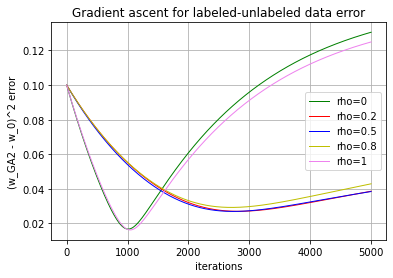

In [588]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import math

def GA(rho):
    n = 100  # dimension
    m = 300  # unlabeled data size
    alpha = m/n
    s_Ori = np.ones(n)
    mean1 = -1/np.sqrt(n)*np.ones(n) # s_0 = [1,...,1], sigma_s2 = s_0^2/n =1
    mean2 = 1/np.sqrt(n)*np.ones(n)
    cov = np.identity(n)
    x = np.zeros((m, n)) #unlabeled data
    for i in range(m):
        if random.uniform(0, 1) > rho:
            x[i] = np.random.multivariate_normal(mean2, cov)
        else:
            x[i] = np.random.multivariate_normal(mean1, cov)

    m_la = 100 #labeled data
    alpha_l = m_la/n

    x_data = np.zeros((m_la, n)) #labeled data
    y_label = np.zeros(m_la)
    for i in range(m_la):
        if random.uniform(0, 1) > rho:
            y_label[i] = 1
            x_data[i] = np.random.multivariate_normal(mean2, cov)
        else:
            y_label[i] = -1
            x_data[i] = np.random.multivariate_normal(mean1, cov)
            
    eps =1e-8
    s_init= 2*np.ones(n)
    s_new = np.zeros(n)
    sum_la = np.zeros(n)
    #rho = 0.8
    gamma = 1e-4
    for i in range(m_la):
        sum_la += x_data[i]*y_label[i]/(np.sqrt(n))
    iter_ = 0
    maxiter_ =5000
    Error = []
    while True:
        sum_un = np.zeros(n)
        for i in range(m):
            sum_un+= (2*rho*np.cosh(x[i]@s_init/np.sqrt(n))-math.exp(-x[i]@s_init/np.sqrt(n)))/(2*rho*np.sinh(x[i]@s_init/np.sqrt(n))+math.exp(-x[i]@s_init/np.sqrt(n)))*x[i]/np.sqrt(n)
        s_new = s_init + gamma*(-(alpha_l+alpha+1)*s_init + sum_la + sum_un)
        Error.append(LA.norm(s_new - s_Ori)/n)
        if LA.norm(s_new - s_init)<eps or iter_>maxiter_:
            break
        s_init = s_new
        iter_+=1
    return s_new,Error

G1 = GA(0)
G2 = GA(0.2)
G3 = GA(0.5)
G4 = GA(0.8)
G5 = GA(1)
iterPlot = []
for i in range(5002):
    iterPlot.append(i)
plt.plot(iterPlot,G1[1],"g-",label="rho=0",linewidth=1)
plt.plot(iterPlot,G2[1],"r-",label="rho=0.2",linewidth=1)
plt.plot(iterPlot,G3[1],"b-",label="rho=0.5",linewidth=1)
plt.plot(iterPlot,G4[1],"y-",label="rho=0.8",linewidth=1)
plt.plot(iterPlot,G5[1],"violet",label="rho=1",linewidth=1)
print("rho=0",G1[0][-1])
print("rho=0.2",G2[0][-1])
print("rho=0.5",G3[0][-1])
print("rho=0.8",G4[0][-1])
print("rho=1",G5[0][-1])
plt.title("Gradient ascent for labeled-unlabeled data error")
plt.ylabel("(w_GA2 - w_0)^2 error")
plt.xlabel("iterations")
plt.grid()
plt.legend()
plt.show() 

In [589]:
print(G1[1][-1])
print(G2[1][-1])
print(G3[1][-1])
print(G4[1][-1])
print(G5[1][-1])

0.13053509468878963
0.03865146707685251
0.03846435166374476
0.04292634344775029
0.12492378338018428


In [591]:
print(G1[0][-1])
print(G2[0][-1])
print(G3[0][-1])
print(G4[0][-1])
print(G5[0][-1])

0.24979653678650598
0.485619790675038
0.5646029787052244
0.6603401469776353
-0.26970593762932954


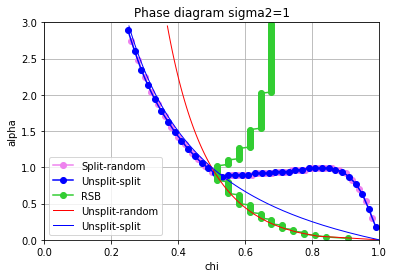

In [599]:
#Homework7 Microscopic dynamical instability or replica symmetry breaking (RSB)
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time
start_time = time.time()

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p,t):
    return np.tanh(p+np.sqrt(t)*y_s(p,t))

def T(p,t): #T function
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha,chi):
    alpha_l = 1e-5
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_ = 0
    k_collec = []
    sigma_collec = []
    k_collec.append(0.01)
    sigma_collec.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_+=1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        #k_new = alpha*chi*sum_f
        #sigma_new = alpha*chi**2*sum_f2
        k_new = chi*(alpha_l + alpha*sum_f)
        sigma_new = chi**2*(alpha_l + alpha*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collec.append(k_new)
        sigma_collec.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return iter_,k_collec,sigma_collec

def mdiRsb(alpha,chi):
    sigma_s2=1
    k=se2(alpha,chi)[1][-1]
    sigma_2=se2(alpha,chi)[2][-1]
    sum_t = 0
    for z in np.arange(-10,10,0.1):
        sum_t += np.exp(-1/2*z**2)*T(k*sigma_s2+np.sqrt(k**2*sigma_s2+sigma_2)*z,chi)**2/np.sqrt(2*np.pi)/10
    return alpha*chi**2*sum_t

alpc = []
chic = []
for i in np.arange(0,3,0.02):
    l = 0
    r = 1
    m = (l+r)/2
    flag=0
    while l<=r:
        if mdiRsb(i,m)<1:
            l = m+0.02
        else:
            r = m-0.02
            flag=1
        m = (l+r)/2
    if flag ==1:
        alpc.append(i)
        chic.append(m)

Unsplit_random_alpha = []
Unsplit_random_chi = []
Unsplit_split_chi = []
for i in np.arange(0,3,0.05):
    Unsplit_random_alpha.append(i)
    Unsplit_random_chi.append(1/(1+np.sqrt(i)))
    Unsplit_split_chi.append(1/(1+i))
    
USchi = []
USalpha= []
for chi in np.arange(0.01,1,0.02):
    eps=1e-4
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.02
        else:
            l = m+0.02
        m = (l+r)/2
    if flag:
        USchi.append(chi)
        USalpha.append(m)

Split_random_alpha = []
Split_random_chi = []
for chi in np.arange(0,1,0.02):
    eps=1e-4
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.02
        else:
            l = m+0.02
        m = (l+r)/2
    if flag:
        Split_random_chi.append(chi)
        Split_random_alpha.append(m)

plt.plot(Split_random_chi,Split_random_alpha,c="violet",label="Split-random",marker="o")        
plt.plot(USchi,USalpha,c="b",label="Unsplit-split",marker="o")    
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()   

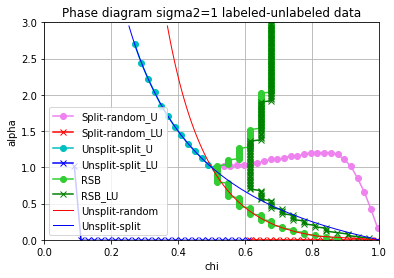

In [607]:
#Homework7 Microscopic dynamical instability or replica symmetry breaking (RSB)
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time
start_time = time.time()

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p,t):
    return np.tanh(p+np.sqrt(t)*y_s(p,t))

def T(p,t): #T function
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha,chi):
    #alpha_l = 1e-2
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_ = 0
    k_collec = []
    sigma_collec = []
    k_collec.append(0.01)
    sigma_collec.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_+=1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        #k_new = alpha*chi*sum_f
        #sigma_new = alpha*chi**2*sum_f2
        k_new = chi*(alpha_l + alpha*sum_f)
        sigma_new = chi**2*(alpha_l + alpha*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collec.append(k_new)
        sigma_collec.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return iter_,k_collec,sigma_collec

def mdiRsb(alpha_l,alpha,chi):
    sigma_s2=1
    k=se2(alpha_l,alpha,chi)[1][-1]
    sigma_2=se2(alpha_l,alpha,chi)[2][-1]
    sum_t = 0
    for z in np.arange(-10,10,0.1):
        sum_t += np.exp(-1/2*z**2)*T(k*sigma_s2+np.sqrt(k**2*sigma_s2+sigma_2)*z,chi)**2/np.sqrt(2*np.pi)/10
    return alpha*chi**2*sum_t

alpc = []
chic = []
for i in np.arange(0,3,0.02):
    l = 0
    r = 1
    m = (l+r)/2
    flag=0
    while l<=r:
        if mdiRsb(0,i,m)<1:
            l = m+0.02
        else:
            r = m-0.02
            flag=1
        m = (l+r)/2
    if flag ==1:
        alpc.append(i)
        chic.append(m)
        
alpc_l = []
chic_l = []
for i in np.arange(0,3,0.02):
    l = 0
    r = 1
    m = (l+r)/2
    flag=0
    while l<=r:
        if mdiRsb(0.01,i,m)<1:
            l = m+0.02
        else:
            r = m-0.02
            flag=1
        m = (l+r)/2
    if flag ==1:
        alpc_l.append(i)
        chic_l.append(m)

Unsplit_random_alpha = []
Unsplit_random_chi = []
Unsplit_split_chi = []
for i in np.arange(0,3,0.05):
    Unsplit_random_alpha.append(i)
    Unsplit_random_chi.append(1/(1+np.sqrt(i)))
    Unsplit_split_chi.append(1/(1+i))
    
USchi = []
USalpha= []
for chi in np.arange(0.01,min(chic),0.02):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.02
        else:
            l = m+0.02
        m = (l+r)/2
    if flag:
        USchi.append(chi)
        USalpha.append(m)
        
USchi_l = []
USalpha_l = []
for chi in np.arange(0.01,min(chic_l),0.02):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0.01,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.02
        else:
            l = m+0.02
        m = (l+r)/2
    if flag:
        USchi_l.append(chi)
        USalpha_l.append(m)

Split_random_alpha = []
Split_random_chi = []
for chi in np.arange(min(chic),1,0.02):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.02
        else:
            l = m+0.02
        m = (l+r)/2
    if flag:
        Split_random_chi.append(chi)
        Split_random_alpha.append(m)
        
Split_random_alpha_l = []
Split_random_chi_l = []
for chi in np.arange(min(chic_l),1,0.02):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0.01,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.02
        else:
            l = m+0.02
        m = (l+r)/2
    if flag:
        Split_random_chi_l.append(chi)
        Split_random_alpha_l.append(m)

plt.plot(Split_random_chi,Split_random_alpha,c="violet",label="Split-random_U",marker="o")    
plt.plot(Split_random_chi_l,Split_random_alpha_l,c="r",label="Split-random_LU",marker="x")   
plt.plot(USchi,USalpha,c="c",label="Unsplit-split_U",marker="o")
plt.plot(USchi_l,USalpha_l,c="b",label="Unsplit-split_LU",marker="x")    
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

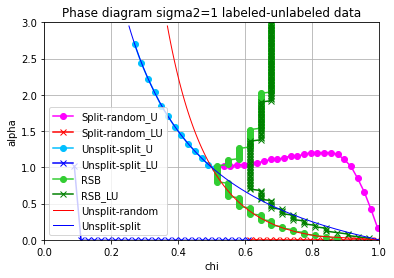

In [616]:
plt.plot(Split_random_chi,Split_random_alpha,c="fuchsia",label="Split-random_U",marker="o")    
plt.plot(Split_random_chi_l,Split_random_alpha_l,c="r",label="Split-random_LU",marker="x")   
plt.plot(USchi,USalpha,c="deepskyblue",label="Unsplit-split_U",marker="o")
plt.plot(USchi_l,USalpha_l,c="b",label="Unsplit-split_LU",marker="x")    
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show() 

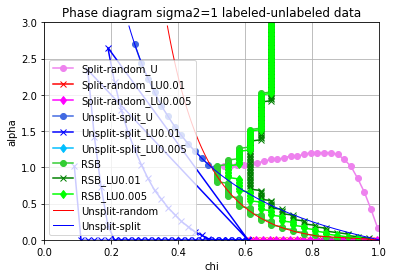

In [618]:
Split_random_alpha_l2 = []
Split_random_chi_l2 = []
for chi in np.arange(min(chic_l),1,0.02):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0.002,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.02
        else:
            l = m+0.02
        m = (l+r)/2
    if flag:
        Split_random_chi_l2.append(chi)
        Split_random_alpha_l2.append(m)
        
USchi_l2 = []
USalpha_l2 = []
for chi in np.arange(0.01,min(chic_l),0.02):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0.002,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.02
        else:
            l = m+0.02
        m = (l+r)/2
    if flag:
        USchi_l.append(chi)
        USalpha_l.append(m)

alpc_l2 = []
chic_l2 = []
for i in np.arange(0,3,0.02):
    l = 0
    r = 1
    m = (l+r)/2
    flag=0
    while l<=r:
        if mdiRsb(0.002,i,m)<1:
            l = m+0.02
        else:
            r = m-0.02
            flag=1
        m = (l+r)/2
    if flag ==1:
        alpc_l2.append(i)
        chic_l2.append(m)
        
plt.plot(Split_random_chi,Split_random_alpha,c="violet",label="Split-random_U",marker="o")    
plt.plot(Split_random_chi_l,Split_random_alpha_l,c="r",label="Split-random_LU0.01",marker="x")
plt.plot(Split_random_chi_l2,Split_random_alpha_l2,c="fuchsia",label="Split-random_LU0.005",marker="d")     
plt.plot(USchi,USalpha,c="royalblue",label="Unsplit-split_U",marker="o")
plt.plot(USchi_l,USalpha_l,c="b",label="Unsplit-split_LU0.01",marker="x")
plt.plot(USchi_l2,USalpha_l2,c="deepskyblue",label="Unsplit-split_LU0.005",marker="d")
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
plt.plot(chic_l,alpc_l,c="g",label="RSB_LU0.01",marker="x")
plt.plot(chic_l2,alpc_l2,c="lime",label="RSB_LU0.005",marker="d")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show() 

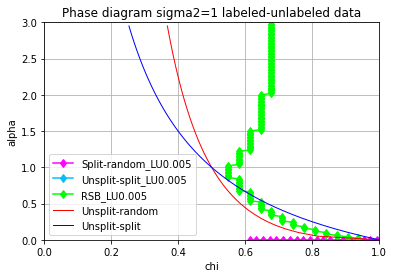

In [622]:
#plt.plot(Split_random_chi,Split_random_alpha,c="violet",label="Split-random_U",marker="o")    
#plt.plot(Split_random_chi_l,Split_random_alpha_l,c="r",label="Split-random_LU0.01",marker="x")
plt.plot(Split_random_chi_l2,Split_random_alpha_l2,c="fuchsia",label="Split-random_LU0.005",marker="d")     
#plt.plot(USchi,USalpha,c="royalblue",label="Unsplit-split_U",marker="o")
#plt.plot(USchi_l,USalpha_l,c="b",label="Unsplit-split_LU0.01",marker="x")
plt.plot(USchi_l2,USalpha_l2,c="deepskyblue",label="Unsplit-split_LU0.005",marker="d")
#plt.plot(chic,alpc,c="limegreen",label="RSB_U",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU0.01",marker="x")
plt.plot(chic_l2,alpc_l2,c="lime",label="RSB_LU0.005",marker="d")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()

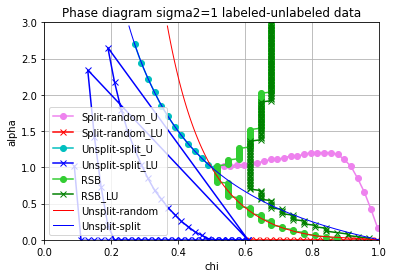

In [623]:
plt.plot(Split_random_chi,Split_random_alpha,c="violet",label="Split-random_U",marker="o")    
plt.plot(Split_random_chi_l,Split_random_alpha_l,c="r",label="Split-random_LU",marker="x")   
plt.plot(USchi,USalpha,c="c",label="Unsplit-split_U",marker="o")
plt.plot(USchi_l,USalpha_l,c="b",label="Unsplit-split_LU",marker="x")    
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [6]:
#Homework7 Microscopic dynamical instability or replica symmetry breaking (RSB)
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time
start_time = time.time()

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p,t):
    return np.tanh(p+np.sqrt(t)*y_s(p,t))

def T(p,t): #T function
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha,chi):
    #alpha_l = 1e-2
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_ = 0
    k_collec = []
    sigma_collec = []
    k_collec.append(0.01)
    sigma_collec.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_+=1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        #k_new = alpha*chi*sum_f
        #sigma_new = alpha*chi**2*sum_f2
        k_new = chi*(alpha_l + alpha*sum_f)
        sigma_new = chi**2*(alpha_l + alpha*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collec.append(k_new)
        sigma_collec.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return iter_,k_collec,sigma_collec

def mdiRsb(alpha_l,alpha,chi):
    sigma_s2=1
    k=se2(alpha_l,alpha,chi)[1][-1]
    sigma_2=se2(alpha_l,alpha,chi)[2][-1]
    sum_t = 0
    for z in np.arange(-10,10,0.1):
        sum_t += np.exp(-1/2*z**2)*T(k*sigma_s2+np.sqrt(k**2*sigma_s2+sigma_2)*z,chi)**2/np.sqrt(2*np.pi)/10
    return alpha*chi**2*sum_t

USchi_U = []
USalpha_U= []
for chi in np.arange(0.01,1,0.05):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0,m,chi)[1][-1]>eps:# and se2(0,m,chi)[2][-1]>eps:
            flag = 1
            r = m-0.05
        else:
            l = m+0.05
        m = (l+r)/2
    if flag:#and se2(0,m,chi)[2][-1]<eps:
        USchi_U.append(chi)
        USalpha_U.append(m)   

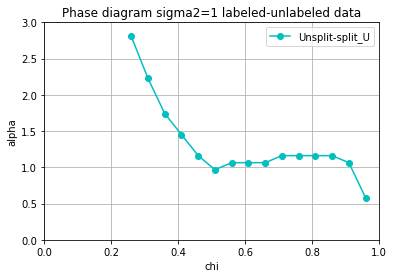

In [7]:
#plt.plot(Split_random_chi_U,Split_random_alpha_U,c="violet",label="Split-random_U",marker="o")    
#plt.plot(Split_random_chi_l2,Split_random_alpha_l2,c="r",label="Split-random_LU",marker="x")   
plt.plot(USchi_U,USalpha_U,c="c",label="Unsplit-split_U",marker="o")
#plt.plot(USchi_l,USalpha_l,c="b",label="Unsplit-split_LU",marker="x")    
#plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

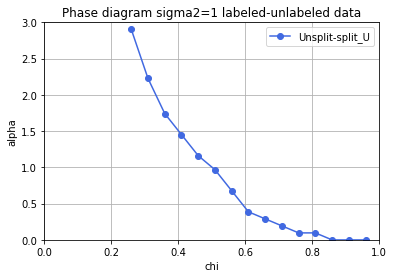

In [12]:
USchi_U2 = []
USalpha_U2= []
for chi in np.arange(0.01,1,0.05):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0,m,chi)[2][-1]>eps:# and se2(0,m,chi)[2][-1]>eps:
            flag = 1
            r = m-0.05
        else:
            l = m+0.05
        m = (l+r)/2
    if flag:#and se2(0,m,chi)[2][-1]<eps:
        USchi_U2.append(chi)
        USalpha_U2.append(m)
#plt.plot(Split_random_chi_U,Split_random_alpha_U,c="violet",label="Split-random_U",marker="o")    
#plt.plot(Split_random_chi_l2,Split_random_alpha_l2,c="r",label="Split-random_LU",marker="x")   
plt.plot(USchi_U2,USalpha_U2,c="royalblue",label="Unsplit-split_U",marker="o")
#plt.plot(USchi_l,USalpha_l,c="b",label="Unsplit-split_LU",marker="x")    
#plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [15]:
USalpha_U2

[2.9046874999999996,
 2.2265625,
 1.7421875,
 1.4515625,
 1.1609375000000002,
 0.9671875,
 0.6765625,
 0.38593749999999993,
 0.2890625,
 0.19218749999999998,
 0.0953125,
 0.0953125,
 -0.0015625000000000049,
 -0.0015625000000000049,
 -0.0015625000000000049]

In [16]:
USalpha_U

[2.8078125,
 2.2265625,
 1.7421875,
 1.4515625,
 1.1609375000000002,
 0.9671875,
 1.0640625,
 1.0640625,
 1.0640625,
 1.1609375000000002,
 1.1609375000000002,
 1.1609375000000002,
 1.1609375000000002,
 1.0640625,
 0.5796875]

In [25]:
l = len(USchi_U)-1
target = 0
for i in range(l,-1,-1):
    if USalpha_U[i] == USalpha_U2[i]:
        target = i
        break
target

5

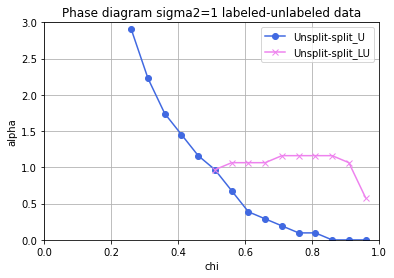

In [27]:
#plt.plot(Split_random_chi_U,Split_random_alpha_U,c="violet",label="Split-random_U",marker="o")    
#plt.plot(Split_random_chi_l2,Split_random_alpha_l2,c="r",label="Split-random_LU",marker="x")   
plt.plot(USchi_U2,USalpha_U2,c="royalblue",label="Unsplit-split_U",marker="o")
plt.plot(USchi_U[target:],USalpha_U[target:],c="violet",label="Unsplit-split_LU",marker="x")    
#plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [9]:
Split_random_alpha_l2 = []
Split_random_chi_l2 = []
for chi in np.arange(0.01,1,0.05):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0,m,chi)[1][-1]>eps and se2(0,m,chi)[2][-1]>eps :
            flag = 1
            r = m-0.05
        else:
            l = m+0.05
        m = (l+r)/2
    if flag:
        Split_random_chi_l2.append(chi)
        Split_random_alpha_l2.append(m)

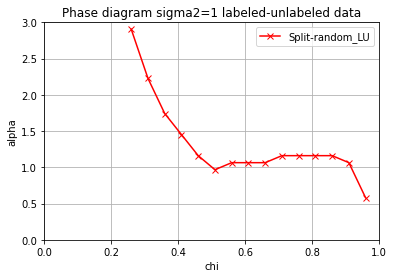

In [10]:
#plt.plot(Split_random_chi_U,Split_random_alpha_U,c="violet",label="Split-random_U",marker="o")    
plt.plot(Split_random_chi_l2,Split_random_alpha_l2,c="r",label="Split-random_LU",marker="x")   
#plt.plot(USchi_U,USalpha_U,c="c",label="Unsplit-split_U",marker="o")
#plt.plot(USchi_l,USalpha_l,c="b",label="Unsplit-split_LU",marker="x")    
#plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show() 

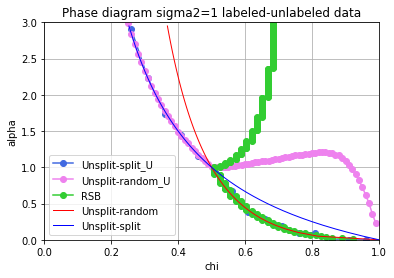

In [44]:
#Homework8 Phase Diagram labeled-unlabeled
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time
start_time = time.time()

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p,t):
    return np.tanh(p+np.sqrt(t)*y_s(p,t))

def T(p,t): #T function
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha_u,chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_ = 0
    k_collec = []
    sigma_collec = []
    k_collec.append(0.01)
    sigma_collec.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_+=1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        #k_new = alpha*chi*sum_f
        #sigma_new = alpha*chi**2*sum_f2
        k_new = chi*(alpha_l + alpha_u*sum_f)
        sigma_new = chi**2*(alpha_l + alpha_u*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collec.append(k_new)
        sigma_collec.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return iter_,k_collec,sigma_collec

def mdiRsb(alpha_l,alpha_u,chi):
    sigma_s2=1
    k=se2(alpha_l,alpha_u,chi)[1][-1]
    sigma_2=se2(alpha_l,alpha_u,chi)[2][-1]
    sum_t = 0
    for z in np.arange(-10,10,0.1):
        sum_t += np.exp(-1/2*z**2)*T(k*sigma_s2+np.sqrt(k**2*sigma_s2+sigma_2)*z,chi)**2/np.sqrt(2*np.pi)/10
    return alpha_u*chi**2*sum_t

URchi_U = []
URalpha_U= []
for chi in np.arange(0.01,1,0.01):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
        m = (l+r)/2
    if flag:
        URchi_U.append(chi)
        URalpha_U.append(m)

USchi_U2 = []
USalpha_U2= []
for chi in np.arange(0.01,1,0.01):
    eps=1e-3
    l = 0
    r = 3
    m = (l+r)/2
    flag = 0
    while l<=r:
        if se2(0,m,chi)[2][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
        m = (l+r)/2
    if flag:
        USchi_U2.append(chi)
        USalpha_U2.append(m)
        
l = len(USchi_U)-1
target = 0
for i in range(l,-1,-1):
    if URalpha_U[i] == USalpha_U2[i]:
        target = i
        break

alpc = []
chic = []
for i in np.arange(0,3,0.01):
    l = 0
    r = 1
    m = (l+r)/2
    flag=0
    while l<=r:
        if mdiRsb(0,i,m)<1:
            l = m+0.01
        else:
            r = m-0.01
            flag=1
        m = (l+r)/2
    if flag ==1:
        alpc.append(i)
        chic.append(m)

Unsplit_random_alpha = []
Unsplit_random_chi = []
Unsplit_split_chi = []
for i in np.arange(0,3,0.05):
    Unsplit_random_alpha.append(i)
    Unsplit_random_chi.append(1/(1+np.sqrt(i)))
    Unsplit_split_chi.append(1/(1+i))
           
plt.plot(USchi_U,USalpha_U,c="royalblue",label="Unsplit-split_U",marker="o")
plt.plot(URchi_U[target:],URalpha_U[target:],c="violet",label="Unsplit-random_U",marker="o")    
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

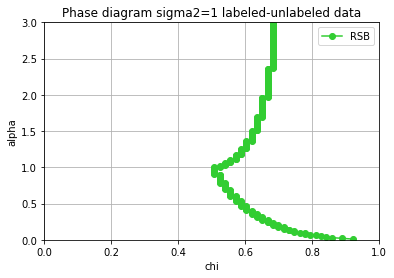

In [49]:
#plt.plot(USchi_U,USalpha_U,c="royalblue",label="Unsplit-split_U",marker="o")
#plt.plot(URchi_U[target:],URalpha_U[target:],c="violet",label="Unsplit-random_U",marker="o")    
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

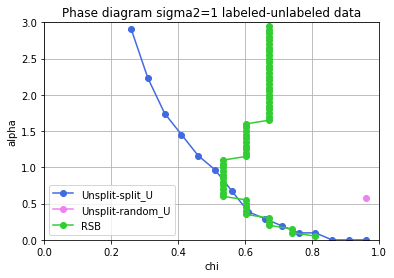

In [35]:
plt.plot(USchi_U,USalpha_U,c="royalblue",label="Unsplit-split_U",marker="o")
plt.plot(URchi_U[target:],URalpha_U[target:],c="violet",label="Unsplit-random_U",marker="o")    
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [40]:
URalpha_U

[2.8078125,
 2.2265625,
 1.7421875,
 1.4515625,
 1.1609375000000002,
 0.9671875,
 1.0640625,
 1.0640625,
 1.0640625,
 1.1609375000000002,
 1.1609375000000002,
 1.1609375000000002,
 1.1609375000000002,
 1.0640625,
 0.5796875]

In [37]:
target

14

In [39]:
USalpha_U2

[2.9046874999999996,
 2.2265625,
 1.7421875,
 1.4515625,
 1.1609375000000002,
 0.9671875,
 0.6765625,
 0.38593749999999993,
 0.2890625,
 0.19218749999999998,
 0.0953125,
 0.0953125,
 -0.0015625000000000049,
 -0.0015625000000000049,
 -0.0015625000000000049]

In [41]:
l = len(USchi_U)-1
target = 0
for i in range(l,-1,-1):
    if URalpha_U[i] == USalpha_U2[i]:
        target = i
        break

In [42]:
target

5

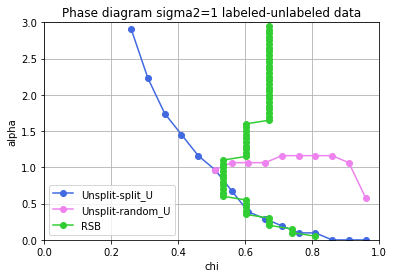

In [43]:
plt.plot(USchi_U,USalpha_U,c="royalblue",label="Unsplit-split_U",marker="o")
plt.plot(URchi_U[target:],URalpha_U[target:],c="violet",label="Unsplit-random_U",marker="o")    
plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [50]:
#Homework8 Phase Diagram labeled-unlabeled
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time
start_time = time.time()

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p,t):
    return np.tanh(p+np.sqrt(t)*y_s(p,t))

def T(p,t): #T function
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha_u,chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-8
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_ = 0
    k_collec = []
    sigma_collec = []
    k_collec.append(0.01)
    sigma_collec.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_+=1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        #k_new = alpha*chi*sum_f
        #sigma_new = alpha*chi**2*sum_f2
        k_new = chi*(alpha_l + alpha_u*sum_f)
        sigma_new = chi**2*(alpha_l + alpha_u*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collec.append(k_new)
        sigma_collec.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return iter_,k_collec,sigma_collec

def mdiRsb(alpha_l,alpha_u,chi):
    sigma_s2=1
    k=se2(alpha_l,alpha_u,chi)[1][-1]
    sigma_2=se2(alpha_l,alpha_u,chi)[2][-1]
    sum_t = 0
    for z in np.arange(-10,10,0.1):
        sum_t += np.exp(-1/2*z**2)*T(k*sigma_s2+np.sqrt(k**2*sigma_s2+sigma_2)*z,chi)**2/np.sqrt(2*np.pi)/10
    return alpha_u*chi**2*sum_t

In [51]:
U_chi_S = []
U_alpha_S= []
for chi in np.arange(0.01,1,0.05):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_S.append(chi)
        U_alpha_S.append(m)

U_chi_R = []
U_alpha_R= []
for chi in np.arange(0.01,1,0.05):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_R.append(chi)
        U_alpha_R.append(m)

In [55]:
U_chi_R2 = []
U_alpha_R2= []
for chi in np.arange(0.01,1,0.05):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0,m,chi)[2][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_R2.append(chi)
        U_alpha_R2.append(m)

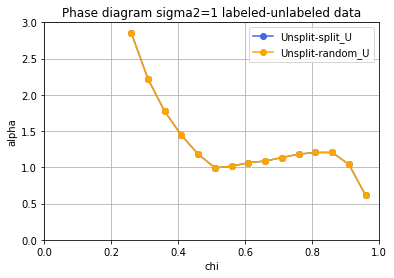

In [54]:
plt.plot(U_chi_S,U_alpha_S,c="royalblue",label="Unsplit-split_U",marker="o")
plt.plot(U_chi_R,U_alpha_R,c="orange",label="Unsplit-random_U",marker="o")
#plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

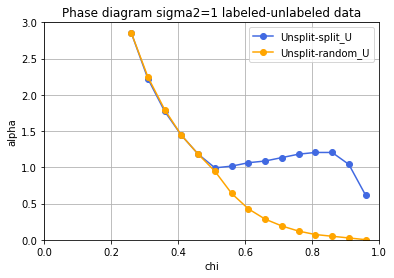

In [56]:
plt.plot(U_chi_S,U_alpha_S,c="royalblue",label="Unsplit-split_U",marker="o")
plt.plot(U_chi_R2,U_alpha_R2,c="orange",label="Unsplit-random_U",marker="o")
#plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [64]:
l = len(U_alpha_R2)
eps = 1e-1
target = 0
for i in range(l):
    if abs(U_alpha_R2[i] - U_alpha_S[i])>eps:
        target=i
        break
target

6

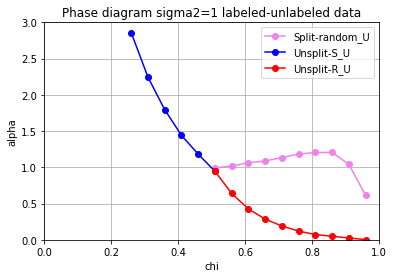

In [69]:
plt.plot(U_chi_S[target-1:],U_alpha_S[target-1:],c="violet",label="Split-random_U",marker="o")
plt.plot(U_chi_R2[:target],U_alpha_R2[:target],c="b",label="Unsplit-S_U",marker="o")
plt.plot(U_chi_R2[target-1:],U_alpha_R2[target-1:],c="r",label="Unsplit-R_U",marker="o")
#plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [59]:
U_alpha_R2

[2.856640625,
 2.243203125,
 1.794921875,
 1.441015625,
 1.1814843750000001,
 0.9455468750000001,
 0.6388281250000001,
 0.426484375,
 0.284921875,
 0.190546875,
 0.11976562499999997,
 0.072578125,
 0.048984375,
 0.025390624999999997,
 0.001796874999999999]

In [63]:
U_alpha_S

[2.856640625,
 2.219609375,
 1.7713281250000001,
 1.441015625,
 1.1814843750000001,
 0.9927343750000002,
 1.0163281250000002,
 1.063515625,
 1.0871093750000003,
 1.134296875,
 1.1814843750000001,
 1.205078125,
 1.205078125,
 1.039921875,
 0.615234375]

In [82]:
U_chi_S3 = []
U_alpha_S3= []
for chi in np.arange(0.01,1,0.05):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0.001,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_S3.append(chi)
        U_alpha_S3.append(m)
        
U_chi_R3 = []
U_alpha_R3= []
for chi in np.arange(0.001,1,0.05):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0.001,m,chi)[2][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_R3.append(chi)
        U_alpha_R3.append(m)

In [83]:
l2 = len(U_alpha_R3)
eps2 = 1e-1
target2 = 0
for i in range(l2):
    if abs(U_alpha_R3[i] - U_alpha_S3[i])>eps2:
        target2=i
        break
target2

1

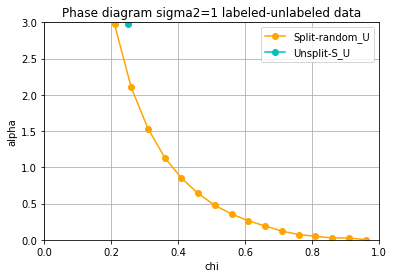

In [90]:
#plt.plot(U_chi_S[target-1:],U_alpha_S[target-1:],c="violet",label="Split-random_U",marker="o")
#plt.plot(U_chi_R2[:target],U_alpha_R2[:target],c="b",label="Unsplit-S_U",marker="o")
#plt.plot(U_chi_R2[target-1:],U_alpha_R2[target-1:],c="r",label="Unsplit-R_U",marker="o")

plt.plot(U_chi_S3[target2-1:],U_alpha_S3[target2-1:],c="orange",label="Split-random_U",marker="o")
plt.plot(U_chi_R3[:target2],U_alpha_R3[:target2],c="c",label="Unsplit-S_U",marker="o")

#plt.plot(U_chi_S3,U_alpha_S3,c="r",label="Split-random_U",marker="o")
#plt.plot(U_chi_R3,U_alpha_R3,c="b",label="Unsplit-S_U",marker="o")
#plt.plot(U_chi_R3[target2-1:],U_alpha_R3[target2-1:],c="g",label="Unsplit-R_U",marker="o")
#plt.plot(chic,alpc,c="limegreen",label="RSB",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [85]:
U_alpha_R3

[2.974609375,
 2.3139843749999995,
 1.8185156249999999,
 1.4646093750000002,
 1.134296875,
 0.756796875,
 0.473671875,
 0.284921875,
 0.16695312499999998,
 0.09617187499999999,
 0.048984375,
 0.025390624999999997,
 0.001796874999999999,
 0.001796874999999999,
 0.001796874999999999]

In [86]:
U_alpha_S3

[2.974609375,
 2.101640625,
 1.5353906249999998,
 1.134296875,
 0.851171875,
 0.6388281250000001,
 0.473671875,
 0.355703125,
 0.261328125,
 0.190546875,
 0.11976562499999997,
 0.072578125,
 0.048984375,
 0.025390624999999997,
 0.025390624999999997,
 0.001796874999999999]

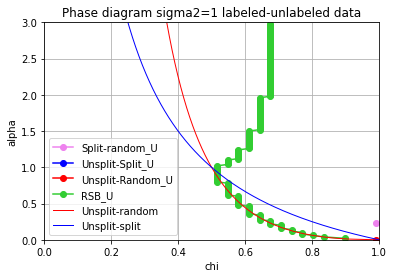

In [91]:
#Homework8 Phase Diagram labeled-unlabeled
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time
start_time = time.time()

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p,t):
    return np.tanh(p+np.sqrt(t)*y_s(p,t))

def T(p,t): #T function
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha_u,chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_ = 0
    k_collec = []
    sigma_collec = []
    k_collec.append(0.01)
    sigma_collec.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_+=1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        #k_new = alpha*chi*sum_f
        #sigma_new = alpha*chi**2*sum_f2
        k_new = chi*(alpha_l + alpha_u*sum_f)
        sigma_new = chi**2*(alpha_l + alpha_u*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collec.append(k_new)
        sigma_collec.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return iter_,k_collec,sigma_collec

def mdiRsb(alpha_l,alpha_u,chi):
    sigma_s2=1
    k=se2(alpha_l,alpha_u,chi)[1][-1]
    sigma_2=se2(alpha_l,alpha_u,chi)[2][-1]
    sum_t = 0
    for z in np.arange(-10,10,0.1):
        sum_t += np.exp(-1/2*z**2)*T(k*sigma_s2+np.sqrt(k**2*sigma_s2+sigma_2)*z,chi)**2/np.sqrt(2*np.pi)/10
    return alpha_u*chi**2*sum_t

alpc = []
chic = []
for i in np.arange(0,3,0.02):
    l = 0
    r = 1
    flag=0
    while l<=r:
        m = (l+r)/2
        if mdiRsb(0,i,m)<1:
            l = m+0.01
        else:
            r = m-0.01
            flag=1
    if flag ==1:
        alpc.append(i)
        chic.append(m)

U_chi_S = []
U_alpha_S= []
for chi in np.arange(0.01,1,0.02):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_S.append(chi)
        U_alpha_S.append(m)

U_chi_R = []
U_alpha_R= []
for chi in np.arange(0.01,1,0.02):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0,m,chi)[2][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_R.append(chi)
        U_alpha_R.append(m)

l = len(U_alpha_R)
eps = 1e-1
target = 0
for i in range(l):
    if abs(U_alpha_R[i] - U_alpha_S[i])>eps:
        target=i
        break

Unsplit_random_alpha = []
Unsplit_random_chi = []
Unsplit_split_chi = []
for i in np.arange(0,3,0.01):
    Unsplit_random_alpha.append(i)
    Unsplit_random_chi.append(1/(1+np.sqrt(i)))
    Unsplit_split_chi.append(1/(1+i))

plt.plot(U_chi_S[target-1:],U_alpha_S[target-1:],c="violet",label="Split-random_U",marker="o")
plt.plot(U_chi_R[:target],U_alpha_R[:target],c="b",label="Unsplit-Split_U",marker="o")
plt.plot(U_chi_R[target-1:],U_alpha_R[target-1:],c="r",label="Unsplit-Random_U",marker="o")
plt.plot(chic,alpc,c="limegreen",label="RSB_U",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()  

In [138]:
alpc

[0.02,
 0.04,
 0.06,
 0.08,
 0.1,
 0.12,
 0.14,
 0.16,
 0.18,
 0.2,
 0.22,
 0.24,
 0.26,
 0.28,
 0.3,
 0.32,
 0.34,
 0.36,
 0.38,
 0.4,
 0.42,
 0.44,
 0.46,
 0.48,
 0.5,
 0.52,
 0.54,
 0.56,
 0.58,
 0.6,
 0.62,
 0.64,
 0.66,
 0.68,
 0.7000000000000001,
 0.72,
 0.74,
 0.76,
 0.78,
 0.8,
 0.8200000000000001,
 0.84,
 0.86,
 0.88,
 0.9,
 0.92,
 0.9400000000000001,
 0.96,
 0.98,
 1.0,
 1.02,
 1.04,
 1.06,
 1.08,
 1.1,
 1.12,
 1.1400000000000001,
 1.16,
 1.18,
 1.2,
 1.22,
 1.24,
 1.26,
 1.28,
 1.3,
 1.32,
 1.34,
 1.36,
 1.3800000000000001,
 1.4000000000000001,
 1.42,
 1.44,
 1.46,
 1.48,
 1.5,
 1.52,
 1.54,
 1.56,
 1.58,
 1.6,
 1.62,
 1.6400000000000001,
 1.6600000000000001,
 1.68,
 1.7,
 1.72,
 1.74,
 1.76,
 1.78,
 1.8,
 1.82,
 1.84,
 1.86,
 1.8800000000000001,
 1.9000000000000001,
 1.92,
 1.94,
 1.96,
 1.98,
 2.0,
 2.02,
 2.04,
 2.06,
 2.08,
 2.1,
 2.12,
 2.14,
 2.16,
 2.18,
 2.2,
 2.22,
 2.24,
 2.2600000000000002,
 2.2800000000000002,
 2.3000000000000003,
 2.32,
 2.34,
 2.36,
 2.38,
 2.4

In [139]:
chic

[0.8984375,
 0.8346875,
 0.8028125,
 0.7709375,
 0.7709375,
 0.7390625,
 0.7390625,
 0.7071875,
 0.7071875,
 0.7071875,
 0.6753125,
 0.6753125,
 0.6753125,
 0.6434374999999999,
 0.6434374999999999,
 0.6434374999999999,
 0.6434374999999999,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796

In [92]:
U_alpha_R

[2.715078125,
 2.4555468749999996,
 2.243203125,
 2.0308593750000004,
 1.865703125,
 1.724140625,
 1.582578125,
 1.441015625,
 1.3230468750000002,
 1.2286718749999999,
 1.134296875,
 1.039921875,
 0.9455468750000001,
 0.803984375,
 0.686015625,
 0.591640625,
 0.497265625,
 0.426484375,
 0.355703125,
 0.308515625,
 0.261328125,
 0.214140625,
 0.190546875,
 0.14335937499999998,
 0.11976562499999997,
 0.09617187499999999,
 0.072578125,
 0.072578125,
 0.048984375,
 0.048984375,
 0.025390624999999997,
 0.025390624999999997,
 0.025390624999999997,
 0.025390624999999997,
 0.001796874999999999,
 0.001796874999999999,
 0.001796874999999999]

In [93]:
U_alpha_S

[2.998203125,
 2.691484375,
 2.4555468749999996,
 2.219609375,
 2.0308593750000004,
 1.865703125,
 1.7005468750000001,
 1.558984375,
 1.441015625,
 1.3230468750000002,
 1.2286718749999999,
 1.134296875,
 1.039921875,
 0.9927343750000002,
 1.0163281250000002,
 1.0163281250000002,
 1.0163281250000002,
 1.039921875,
 1.039921875,
 1.063515625,
 1.0871093750000003,
 1.0871093750000003,
 1.1107031250000001,
 1.134296875,
 1.134296875,
 1.1578906249999998,
 1.1814843750000001,
 1.1814843750000001,
 1.205078125,
 1.205078125,
 1.205078125,
 1.1814843750000001,
 1.134296875,
 1.039921875,
 0.8983593750000001,
 0.733203125,
 0.497265625,
 0.237734375]

In [140]:
U_chi_S

[0.24999999999999997,
 0.26999999999999996,
 0.29,
 0.30999999999999994,
 0.32999999999999996,
 0.35,
 0.36999999999999994,
 0.38999999999999996,
 0.4099999999999999,
 0.42999999999999994,
 0.44999999999999996,
 0.4699999999999999,
 0.48999999999999994,
 0.5099999999999999,
 0.5299999999999999,
 0.5499999999999999,
 0.57,
 0.59,
 0.6099999999999999,
 0.6299999999999999,
 0.6499999999999999,
 0.6699999999999999,
 0.69,
 0.7099999999999999,
 0.7299999999999999,
 0.7499999999999999,
 0.7699999999999999,
 0.7899999999999999,
 0.8099999999999998,
 0.8299999999999998,
 0.8499999999999999,
 0.8699999999999999,
 0.8899999999999999,
 0.9099999999999999,
 0.9299999999999998,
 0.9499999999999998,
 0.9699999999999999,
 0.9899999999999999]

In [141]:
U_chi_R

[0.26999999999999996,
 0.29,
 0.30999999999999994,
 0.32999999999999996,
 0.35,
 0.36999999999999994,
 0.38999999999999996,
 0.4099999999999999,
 0.42999999999999994,
 0.44999999999999996,
 0.4699999999999999,
 0.48999999999999994,
 0.5099999999999999,
 0.5299999999999999,
 0.5499999999999999,
 0.57,
 0.59,
 0.6099999999999999,
 0.6299999999999999,
 0.6499999999999999,
 0.6699999999999999,
 0.69,
 0.7099999999999999,
 0.7299999999999999,
 0.7499999999999999,
 0.7699999999999999,
 0.7899999999999999,
 0.8099999999999998,
 0.8299999999999998,
 0.8499999999999999,
 0.8699999999999999,
 0.8899999999999999,
 0.9099999999999999,
 0.9299999999999998,
 0.9499999999999998,
 0.9699999999999999,
 0.9899999999999999]

In [165]:
chic

[0.8984375,
 0.8346875,
 0.8028125,
 0.7709375,
 0.7709375,
 0.7390625,
 0.7390625,
 0.7071875,
 0.7071875,
 0.7071875,
 0.6753125,
 0.6753125,
 0.6753125,
 0.6434374999999999,
 0.6434374999999999,
 0.6434374999999999,
 0.6434374999999999,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5159374999999999,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796

In [167]:
alpc

[0.02,
 0.04,
 0.06,
 0.08,
 0.1,
 0.12,
 0.14,
 0.16,
 0.18,
 0.2,
 0.22,
 0.24,
 0.26,
 0.28,
 0.3,
 0.32,
 0.34,
 0.36,
 0.38,
 0.4,
 0.42,
 0.44,
 0.46,
 0.48,
 0.5,
 0.52,
 0.54,
 0.56,
 0.58,
 0.6,
 0.62,
 0.64,
 0.66,
 0.68,
 0.7000000000000001,
 0.72,
 0.74,
 0.76,
 0.78,
 0.8,
 0.8200000000000001,
 0.84,
 0.86,
 0.88,
 0.9,
 0.92,
 0.9400000000000001,
 0.96,
 0.98,
 1.0,
 1.02,
 1.04,
 1.06,
 1.08,
 1.1,
 1.12,
 1.1400000000000001,
 1.16,
 1.18,
 1.2,
 1.22,
 1.24,
 1.26,
 1.28,
 1.3,
 1.32,
 1.34,
 1.36,
 1.3800000000000001,
 1.4000000000000001,
 1.42,
 1.44,
 1.46,
 1.48,
 1.5,
 1.52,
 1.54,
 1.56,
 1.58,
 1.6,
 1.62,
 1.6400000000000001,
 1.6600000000000001,
 1.68,
 1.7,
 1.72,
 1.74,
 1.76,
 1.78,
 1.8,
 1.82,
 1.84,
 1.86,
 1.8800000000000001,
 1.9000000000000001,
 1.92,
 1.94,
 1.96,
 1.98,
 2.0,
 2.02,
 2.04,
 2.06,
 2.08,
 2.1,
 2.12,
 2.14,
 2.16,
 2.18,
 2.2,
 2.22,
 2.24,
 2.2600000000000002,
 2.2800000000000002,
 2.3000000000000003,
 2.32,
 2.34,
 2.36,
 2.38,
 2.4

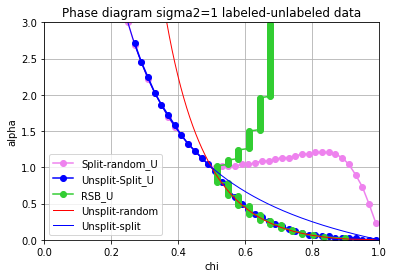

In [102]:
plt.plot(U_chi_S,U_alpha_S,c="violet",label="Split-random_U",marker="o")
plt.plot(U_chi_R,U_alpha_R,c="b",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target-1:],U_alpha_R[target-1:],c="r",label="Unsplit-Random_U",marker="o")
plt.plot(chic,alpc,c="limegreen",label="RSB_U",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()

In [103]:
len(U_alpha_S[1:])

37

In [106]:
l = len(U_alpha_S[1:])

In [108]:
target
for i in range(1,l-1,1):
    if U_alpha_S[i+1]>U_alpha_S[i]:
        target = i
        break

In [109]:
target

13

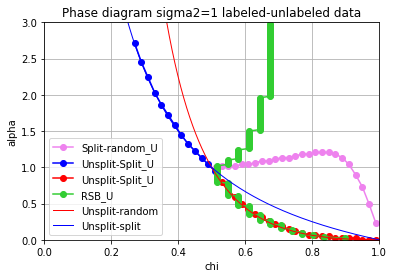

In [118]:
plt.plot(U_chi_S[target:],U_alpha_S[target:],c="violet",label="Split-random_U",marker="o")
plt.plot(U_chi_R[:target],U_alpha_R[:target],c="b",label="Unsplit-Split_U",marker="o")
plt.plot(U_chi_R[target:],U_alpha_R[target:],c="r",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target-1:],U_alpha_R[target-1:],c="r",label="Unsplit-Random_U",marker="o")
plt.plot(chic,alpc,c="limegreen",label="RSB_U",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()

In [119]:
#Homework8 Phase Diagram labeled-unlabeled
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time
start_time = time.time()

def y_s(p,t):#using iteration to solve y^*
    eps = 1e-12 #epsilon
    y_st = 1 #initial y^*
    y_pre = 0
    while LA.norm(y_st-y_pre)>eps:
        y_pre = y_st
        y_st = np.tanh(p+np.sqrt(t)*y_pre)*np.sqrt(t)
    return y_st

def F(p,t):
    return np.tanh(p+np.sqrt(t)*y_s(p,t))

def T(p,t): #T function
    return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

def se2(alpha_l,alpha_u,chi):
    k_t = 0.01
    sigma_s2 = 1
    sigma_t2 = 0
    eps = 1e-6
    parameter_old = np.array([k_t,sigma_t2])
    parameter_new = np.array([1,1])
    iter_ = 0
    k_collec = []
    sigma_collec = []
    k_collec.append(0.01)
    sigma_collec.append(sigma_t2)
    while LA.norm(parameter_new - parameter_old)>eps:
        parameter_old = np.array([k_t,sigma_t2])
        sum_f = 0
        sum_f2 = 0
        iter_+=1
        for z in np.arange(-10,10,0.1):
            sum_f += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)/np.sqrt(2*np.pi)/10
            sum_f2 += np.exp(-1/2*z**2)*F(k_t*sigma_s2+np.sqrt(k_t**2*sigma_s2+sigma_t2)*z,chi)**2/np.sqrt(2*np.pi)/10
        #k_new = alpha*chi*sum_f
        #sigma_new = alpha*chi**2*sum_f2
        k_new = chi*(alpha_l + alpha_u*sum_f)
        sigma_new = chi**2*(alpha_l + alpha_u*sum_f2)
        parameter_new = np.array([k_new,sigma_new])
        k_collec.append(k_new)
        sigma_collec.append(sigma_new)
        k_t = k_new
        sigma_t2 = sigma_new
    return iter_,k_collec,sigma_collec

def mdiRsb(alpha_l,alpha_u,chi):
    sigma_s2=1
    k=se2(alpha_l,alpha_u,chi)[1][-1]
    sigma_2=se2(alpha_l,alpha_u,chi)[2][-1]
    sum_t = 0
    for z in np.arange(-10,10,0.1):
        sum_t += np.exp(-1/2*z**2)*T(k*sigma_s2+np.sqrt(k**2*sigma_s2+sigma_2)*z,chi)**2/np.sqrt(2*np.pi)/10
    return alpha_u*chi**2*sum_t

alpc2 = []
chic2 = []
for i in np.arange(0,3,0.02):
    l = 0
    r = 1
    flag=0
    while l<=r:
        m = (l+r)/2
        if mdiRsb(0.0005,i,m)<1:
            l = m+0.01
        else:
            r = m-0.01
            flag=1
    if flag ==1:
        alpc2.append(i)
        chic2.append(m)

U_chi_S2 = []
U_alpha_S2= []
for chi in np.arange(0.01,1,0.02):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0.0005,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_S2.append(chi)
        U_alpha_S2.append(m)

U_chi_R2 = []
U_alpha_R2= []
for chi in np.arange(0.01,1,0.02):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0.0005,m,chi)[2][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_R2.append(chi)
        U_alpha_R2.append(m)

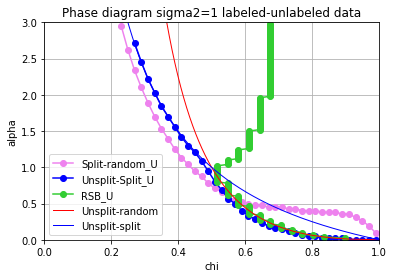

In [120]:
plt.plot(U_chi_S2,U_alpha_S2,c="violet",label="Split-random_U",marker="o")
plt.plot(U_chi_R2,U_alpha_R2,c="b",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target:],U_alpha_R[target:],c="r",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target-1:],U_alpha_R[target-1:],c="r",label="Unsplit-Random_U",marker="o")
plt.plot(chic,alpc,c="limegreen",label="RSB_U",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()

In [160]:
U_chi_S2

[0.22999999999999998,
 0.24999999999999997,
 0.26999999999999996,
 0.29,
 0.30999999999999994,
 0.32999999999999996,
 0.35,
 0.36999999999999994,
 0.38999999999999996,
 0.4099999999999999,
 0.42999999999999994,
 0.44999999999999996,
 0.4699999999999999,
 0.48999999999999994,
 0.5099999999999999,
 0.5299999999999999,
 0.5499999999999999,
 0.57,
 0.59,
 0.6099999999999999,
 0.6299999999999999,
 0.6499999999999999,
 0.6699999999999999,
 0.69,
 0.7099999999999999,
 0.7299999999999999,
 0.7499999999999999,
 0.7699999999999999,
 0.7899999999999999,
 0.8099999999999998,
 0.8299999999999998,
 0.8499999999999999,
 0.8699999999999999,
 0.8899999999999999,
 0.9099999999999999,
 0.9299999999999998,
 0.9499999999999998,
 0.9699999999999999,
 0.9899999999999999]

In [161]:
U_chi_R2

[0.26999999999999996,
 0.29,
 0.30999999999999994,
 0.32999999999999996,
 0.35,
 0.36999999999999994,
 0.38999999999999996,
 0.4099999999999999,
 0.42999999999999994,
 0.44999999999999996,
 0.4699999999999999,
 0.48999999999999994,
 0.5099999999999999,
 0.5299999999999999,
 0.5499999999999999,
 0.57,
 0.59,
 0.6099999999999999,
 0.6299999999999999,
 0.6499999999999999,
 0.6699999999999999,
 0.69,
 0.7099999999999999,
 0.7299999999999999,
 0.7499999999999999,
 0.7699999999999999,
 0.7899999999999999,
 0.8099999999999998,
 0.8299999999999998,
 0.8499999999999999,
 0.8699999999999999,
 0.8899999999999999,
 0.9099999999999999,
 0.9299999999999998,
 0.9499999999999998,
 0.9699999999999999,
 0.9899999999999999]

In [162]:
U_alpha_S2

[2.951015625,
 2.6207031249999995,
 2.3375781249999994,
 2.101640625,
 1.8892968749999999,
 1.7005468750000001,
 1.5353906249999998,
 1.3938281250000002,
 1.2522656250000002,
 1.134296875,
 1.039921875,
 0.9455468750000001,
 0.874765625,
 0.780390625,
 0.709609375,
 0.6624218749999999,
 0.591640625,
 0.544453125,
 0.520859375,
 0.497265625,
 0.473671875,
 0.473671875,
 0.450078125,
 0.450078125,
 0.450078125,
 0.426484375,
 0.426484375,
 0.402890625,
 0.402890625,
 0.402890625,
 0.379296875,
 0.379296875,
 0.379296875,
 0.355703125,
 0.355703125,
 0.308515625,
 0.261328125,
 0.190546875,
 0.09617187499999999]

In [126]:
U_alpha_R2

[2.715078125,
 2.4555468749999996,
 2.219609375,
 2.0308593750000004,
 1.8421093750000002,
 1.7005468750000001,
 1.558984375,
 1.417421875,
 1.2994531249999999,
 1.205078125,
 1.0871093750000003,
 0.9455468750000001,
 0.803984375,
 0.686015625,
 0.5680468750000001,
 0.497265625,
 0.402890625,
 0.332109375,
 0.284921875,
 0.237734375,
 0.190546875,
 0.16695312499999998,
 0.14335937499999998,
 0.11976562499999997,
 0.09617187499999999,
 0.072578125,
 0.048984375,
 0.048984375,
 0.025390624999999997,
 0.025390624999999997,
 0.025390624999999997,
 0.025390624999999997,
 0.001796874999999999,
 0.001796874999999999,
 0.001796874999999999,
 0.001796874999999999,
 0.001796874999999999]

In [163]:
alpc2

[0.02,
 0.04,
 0.06,
 0.08,
 0.1,
 0.12,
 0.14,
 0.16,
 0.18,
 0.2,
 0.22,
 0.24,
 0.26,
 0.28,
 0.3,
 0.32,
 0.34,
 0.36,
 0.38,
 0.4,
 0.42,
 0.44,
 0.46,
 0.48,
 0.5,
 0.52,
 0.54,
 0.56,
 0.58,
 0.6,
 0.62,
 0.64,
 0.66,
 0.68,
 0.7000000000000001,
 0.72,
 0.74,
 0.76,
 0.78,
 0.8,
 0.8200000000000001,
 0.84,
 0.86,
 0.88,
 0.9,
 0.92,
 0.9400000000000001,
 0.96,
 0.98,
 1.0,
 1.02,
 1.04,
 1.06,
 1.08,
 1.1,
 1.12,
 1.1400000000000001,
 1.16,
 1.18,
 1.2,
 1.22,
 1.24,
 1.26,
 1.28,
 1.3,
 1.32,
 1.34,
 1.36,
 1.3800000000000001,
 1.4000000000000001,
 1.42,
 1.44,
 1.46,
 1.48,
 1.5,
 1.52,
 1.54,
 1.56,
 1.58,
 1.6,
 1.62,
 1.6400000000000001,
 1.6600000000000001,
 1.68,
 1.7,
 1.72,
 1.74,
 1.76,
 1.78,
 1.8,
 1.82,
 1.84,
 1.86,
 1.8800000000000001,
 1.9000000000000001,
 1.92,
 1.94,
 1.96,
 1.98,
 2.0,
 2.02,
 2.04,
 2.06,
 2.08,
 2.1,
 2.12,
 2.14,
 2.16,
 2.18,
 2.2,
 2.22,
 2.24,
 2.2600000000000002,
 2.2800000000000002,
 2.3000000000000003,
 2.32,
 2.34,
 2.36,
 2.38,
 2.4

In [164]:
chic2

[0.9303125000000001,
 0.8984375,
 0.8665625000000001,
 0.8346875,
 0.8028125,
 0.8028125,
 0.7709375,
 0.7709375,
 0.7390625,
 0.7390625,
 0.7071875,
 0.7071875,
 0.7071875,
 0.6753125,
 0.6753125,
 0.6753125,
 0.6753125,
 0.6753125,
 0.6434374999999999,
 0.6434374999999999,
 0.6434374999999999,
 0.6434374999999999,
 0.6434374999999999,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5478125,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.5796874999999999,
 0.6115625,
 0.6115625,
 0.6115625,
 0.6115625,
 

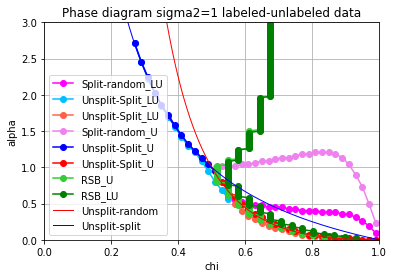

In [159]:
plt.plot(U_chi_S2[16:],U_alpha_S2[16:],c="fuchsia",label="Split-random_LU",marker="o")
plt.plot(U_chi_R2[:15],U_alpha_R2[:15],c="deepskyblue",label="Unsplit-Split_LU",marker="o")
plt.plot(U_chi_R2[15:],U_alpha_R2[15:],c="tomato",label="Unsplit-Split_LU",marker="o")
plt.plot(U_chi_S[target:],U_alpha_S[target:],c="violet",label="Split-random_U",marker="o")
plt.plot(U_chi_R[:target],U_alpha_R[:target],c="b",label="Unsplit-Split_U",marker="o")
plt.plot(U_chi_R[target:],U_alpha_R[target:],c="r",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target:],U_alpha_R[target:],c="r",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target-1:],U_alpha_R[target-1:],c="r",label="Unsplit-Random_U",marker="o")
plt.plot(chic,alpc,c="limegreen",label="RSB_U",marker="o")
plt.plot(chic2,alpc2,c="g",label="RSB_LU",marker="o")
#plt.plot(chic_l,alpc_l,c="g",label="RSB_LU",marker="x")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()

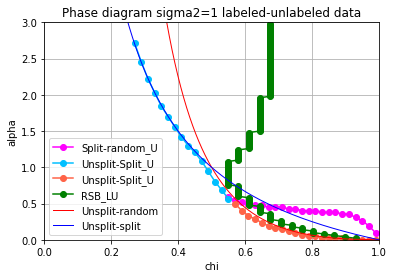

In [158]:
plt.plot(U_chi_S2[16:],U_alpha_S2[16:],c="fuchsia",label="Split-random_U",marker="o")
plt.plot(U_chi_R2[:15],U_alpha_R2[:15],c="deepskyblue",label="Unsplit-Split_U",marker="o")
plt.plot(U_chi_R2[15:],U_alpha_R2[15:],c="tomato",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_S[target:],U_alpha_S[target:],c="violet",label="Split-random_U",marker="o")
#plt.plot(U_chi_R[:target],U_alpha_R[:target],c="b",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target:],U_alpha_R[target:],c="r",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target:],U_alpha_R[target:],c="r",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target-1:],U_alpha_R[target-1:],c="r",label="Unsplit-Random_U",marker="o")
#plt.plot(chic,alpc,c="limegreen",label="RSB_U",marker="o")
plt.plot(chic2,alpc2,c="g",label="RSB_LU",marker="o")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()

In [212]:
U_chi_R5 = []
U_alpha_R5= []
for chi in np.arange(0.01,1,0.01):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0.001,m,chi)[2][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_R5.append(chi)
        U_alpha_R5.append(m)

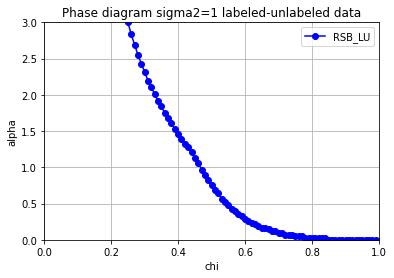

In [213]:
plt.plot(U_chi_R5,U_alpha_R5,c="b",label="RSB_LU",marker="o")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()

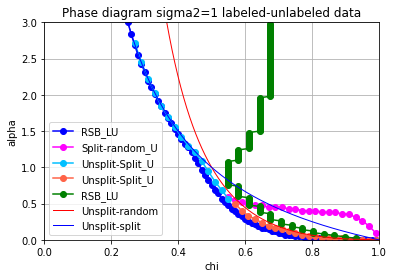

In [214]:
plt.plot(U_chi_R5,U_alpha_R5,c="b",label="RSB_LU",marker="o")
plt.plot(U_chi_S2[16:],U_alpha_S2[16:],c="fuchsia",label="Split-random_U",marker="o")
plt.plot(U_chi_R2[:15],U_alpha_R2[:15],c="deepskyblue",label="Unsplit-Split_U",marker="o")
plt.plot(U_chi_R2[15:],U_alpha_R2[15:],c="tomato",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_S[target:],U_alpha_S[target:],c="violet",label="Split-random_U",marker="o")
#plt.plot(U_chi_R[:target],U_alpha_R[:target],c="b",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target:],U_alpha_R[target:],c="r",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target:],U_alpha_R[target:],c="r",label="Unsplit-Split_U",marker="o")
#plt.plot(U_chi_R[target-1:],U_alpha_R[target-1:],c="r",label="Unsplit-Random_U",marker="o")
#plt.plot(chic,alpc,c="limegreen",label="RSB_U",marker="o")
plt.plot(chic2,alpc2,c="g",label="RSB_LU",marker="o")
plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.legend()
plt.show()

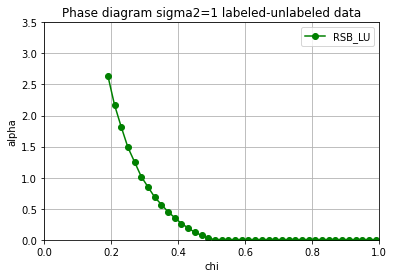

In [215]:
U_chi_R4 = []
U_alpha_R4= []
for chi in np.arange(0.01,1,0.02):
    eps=1e-3
    l = 0
    r = 3
    flag = 0
    while l<=r:
        m = (l+r)/2
        if se2(0.002,m,chi)[1][-1]>eps:
            flag = 1
            r = m-0.01
        else:
            l = m+0.01
    if flag:
        U_chi_R4.append(chi)
        U_alpha_R4.append(m)
        
plt.plot(U_chi_R4,U_alpha_R4,c="g",label="RSB_LU",marker="o")
#plt.plot(Unsplit_random_chi,Unsplit_random_alpha,"r-",label="Unsplit-random",linewidth=1)
#plt.plot(Unsplit_split_chi,Unsplit_random_alpha,"b-",label="Unsplit-split",linewidth=1)
plt.title("Phase diagram sigma2=1 labeled-unlabeled data")
plt.ylabel("alpha")
plt.xlabel("chi")
plt.xlim(0,1)
plt.ylim(0,3.5)
plt.grid()
plt.legend()
plt.show()